This script will overlay larger grids on the 4km pixels and determine if they are burned or unburned by using a 15% requirement of pixels that need to be burned in order to classify it as burned.  It will save tif files and parquet files. I will also give a unique ID to the lareger 1:10 degree cells which will be saved in the parquet files. 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Train XGBoost (Optimized for Speed & Area Accuracy)
-- BUG FIX: Validates FINAL_ROUNDS is an integer --
-- LOGGING ENABLED: Writes to file and screen --

Changes:
1. FIXED: Explicitly casts num_boost_round to int() to prevent tuple errors.
2. FIXED: Phase 2 uses 'binary:logistic'.
3. LOGGING: Captures outputs to 'training_log.txt'.
"""

import os
import sys
import json
import gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyarrow.dataset as ds
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import (
    average_precision_score, 
    log_loss, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)
import xgboost as xgb

# ============================================================
# CONFIG
# ============================================================

RANDOM_STATE = 42
DATASET_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical")
OUT_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_logloss_fast_tuning_2003_2004_v2")

OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "models").mkdir(exist_ok=True)
(OUT_DIR / "figures").mkdir(exist_ok=True)

# Define Log File Path
LOG_FILE = OUT_DIR / "training_log.txt"

FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity",
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min",
    "temperature_2m_max", "build_up_index", "drought_code",
    "duff_moisture_code", "fine_fuel_moisture_code",
    "fire_weather_index", "initial_fire_spread_index",
]

FRACTION_COL = "fraction"
LABEL_COL = "burned"
TEST_YEARS = [2003, 2004]
VAL_SIZE_OF_REMAINING = 0.20 

# TUNING CONFIG
N_ITER_SEARCH = 10            
TUNING_ROUNDS = 1000          
FINAL_ROUNDS  = 4000         
TUNING_SUBSAMPLE = 0.20       

N_JOBS = int(os.environ.get("SLURM_CPUS_PER_TASK", "0")) or os.cpu_count() or 8
USE_GPU = bool(os.environ.get("CUDA_VISIBLE_DEVICES", "").strip())
TREE_METHOD = "gpu_hist" if USE_GPU else "hist"

# ============================================================
# LOGGING HELPER
# ============================================================

class Logger(object):
    """
    Redirects stdout to both the terminal/cell and a file.
    """
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, "w", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        self.log.flush() # Force write immediately

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# ============================================================
# HELPERS
# ============================================================

def iou_from_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    denom = tp + fp + fn
    return float(tp / denom) if denom > 0 else 0.0

def prepare_df_cleaned(df: pd.DataFrame):
    df = df.copy()
    
    # 1. Types & Fraction
    df[FRACTION_COL] = pd.to_numeric(df[FRACTION_COL], errors="coerce").astype("float32")
    df = df[df[FRACTION_COL].notna() & (df[FRACTION_COL] != 0.5)].copy()
    df[LABEL_COL] = (df[FRACTION_COL] > 0.5).astype("uint8")
    
    # 2. Year & B1
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["b1"] = pd.to_numeric(df["b1"], errors="coerce").round().astype("Int64")

    # 3. CRITICAL: Remove Negative FWI (The -9999 Fix)
    fwi_cols = ["duff_moisture_code", "drought_code", "fine_fuel_moisture_code", "build_up_index"]
    for c in fwi_cols:
        if c in df.columns:
            # Filter rows where any FWI col is negative
            df = df[df[c] >= 0]

    # 4. NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=FEATURES + [LABEL_COL, "year"])
    
    # 5. Final Types
    df["b1"] = df["b1"].astype("int32")
    for c in FEATURES:
        if c == "b1": continue
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
        
    return df.copy()

def load_data():
    print(f"Loading: {DATASET_DIR}")
    dset = ds.dataset(str(DATASET_DIR), format="parquet", partitioning="hive")
    cols = FEATURES + [FRACTION_COL, "year"]
    
    available_cols = dset.schema.names
    cols_to_load = [c for c in cols if c in available_cols]
    
    if "year" not in cols_to_load:
        cols_to_load.append("year")
    
    table = dset.to_table(columns=cols_to_load)
    df = table.to_pandas()
    return prepare_df_cleaned(df)

# ============================================================
# TUNING LOGIC
# ============================================================

def build_param_space(neg_pos_ratio):
    return {
        "max_depth": [4, 6, 8, 10],
        "min_child_weight": [1, 5, 10],
        "subsample": [0.7, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.9, 1.0],
        "learning_rate": [0.05, 0.1, 0.2],
        "gamma": [0, 1, 5],
        "scale_pos_weight": [neg_pos_ratio * f for f in [0.5, 1.0, 2.0]],
    }

def train_one_config_fast(dtrain, dval, params, num_rounds):
    fixed_params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": TREE_METHOD,
        "max_bin": 256,
        "seed": RANDOM_STATE,
        "verbosity": 0,
    }
    run_params = {**fixed_params, **params}
    
    booster = xgb.train(
        params=run_params,
        dtrain=dtrain,
        num_boost_round=int(num_rounds), # Ensure int
        evals=[(dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    return booster.best_score, booster.best_iteration, run_params

# ============================================================
# MAIN EXECUTION
# ============================================================

def main():
    # --- START LOGGING ---
    sys.stdout = Logger(str(LOG_FILE))
    print(f"Logging initialized. Writing to: {LOG_FILE}")
    print("-" * 50)
    
    print(f"Starting FAST Training (GPU={USE_GPU})")
    
    # 1. Load & Split
    df = load_data()
    
    mask_test = df["year"].isin(TEST_YEARS)
    df_test = df[mask_test]
    df_tv = df[~mask_test]
    
    print(f"Test Rows: {len(df_test):,}")
    print(f"Train/Val Rows: {len(df_tv):,}")
    
    if len(df_test) == 0:
        raise ValueError("No test data found. Check TEST_YEARS.")
    
    # 2. Train/Val Split
    X_tv = df_tv[FEATURES]
    y_tv = df_tv[LABEL_COL].values
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_tv, y_tv, test_size=VAL_SIZE_OF_REMAINING, 
        random_state=RANDOM_STATE, stratify=y_tv
    )
    
    # 3. FAST TUNING
    print("\n--- Phase 1: Hyperparameter Tuning (on Subsample) ---")
    
    X_tune, _, y_tune, _ = train_test_split(
        X_train, y_train, train_size=TUNING_SUBSAMPLE, 
        random_state=RANDOM_STATE, stratify=y_train
    )
    
    print(f"Tuning on {len(X_tune):,} rows (Subsample)")
    
    dtrain_tune = xgb.DMatrix(X_tune, label=y_tune, nthread=N_JOBS)
    dval_tune   = xgb.DMatrix(X_val, label=y_val, nthread=N_JOBS)
    
    n_pos = y_tune.sum()
    n_neg = len(y_tune) - n_pos
    ratio = n_neg / max(1, n_pos)
    param_dist = build_param_space(ratio)
    sampler = list(ParameterSampler(param_dist, n_iter=N_ITER_SEARCH, random_state=RANDOM_STATE))
    
    best_loss = float("inf")
    best_params = None
    
    for i, p in enumerate(sampler, 1):
        loss, bi, _ = train_one_config_fast(dtrain_tune, dval_tune, p, TUNING_ROUNDS)
        print(f"Iter {i}/{N_ITER_SEARCH} | LogLoss: {loss:.5f} | Best Iter: {bi}")
        if loss < best_loss:
            best_loss = loss
            best_params = p
            
    print("\nBest Tuning LogLoss:", best_loss)
    print("Best Params:", json.dumps(best_params, indent=2))
    
    # 4. FINAL TRAINING
    print("\n--- Phase 2: Final Training (Full Data) ---")
    del dtrain_tune, dval_tune, X_tune, y_tune
    gc.collect()
    
    dtrain_full = xgb.DMatrix(X_train, label=y_train, nthread=N_JOBS)
    dval_full   = xgb.DMatrix(X_val,   label=y_val,   nthread=N_JOBS)
    
    # --- CRITICAL FIX START ---
    final_params = best_params.copy()
    final_params["objective"] = "binary:logistic" 
    final_params["learning_rate"] = 0.05 
    final_params["eval_metric"] = "logloss"
    final_params["tree_method"] = TREE_METHOD
    final_params["max_bin"] = 256
    final_params["seed"] = RANDOM_STATE
    # --- CRITICAL FIX END ---
    
    # FIX: wrap FINAL_ROUNDS in int() to prevent tuple errors
    final_booster = xgb.train(
        params=final_params,
        dtrain=dtrain_full,
        num_boost_round=int(FINAL_ROUNDS),
        evals=[(dval_full, "val")],
        early_stopping_rounds=200,
        verbose_eval=100
    )
    
    final_booster.save_model(str(OUT_DIR / "models" / "xgb_final_logloss.json"))
    
    # 5. EVALUATION
    print("\n--- Phase 3: Evaluation (Years 2003, 2004) ---")
    
    # Threshold Selection
    val_probs = final_booster.predict(dval_full)
    best_thr = 0.5
    best_f1 = 0.0
    thresholds = np.arange(0.1, 0.95, 0.05)
    
    for thr in thresholds:
        v_pred = (val_probs >= thr).astype(np.uint8)
        f1 = f1_score(y_val, v_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
            
    print(f"Selected Threshold (Max Val F1): {best_thr:.2f}")

    # Test Eval
    dtest = xgb.DMatrix(df_test[FEATURES], label=df_test[LABEL_COL].values, nthread=N_JOBS)
    test_probs = final_booster.predict(dtest)
    y_test = df_test[LABEL_COL].values
    
    # Area Metrics
    actual_pixels = y_test.sum()
    predicted_pixels = np.sum(test_probs)
    diff = predicted_pixels - actual_pixels
    
    print("\n=== AREA PREDICTION (Sum of Probabilities) ===")
    print(f"Total Observed Burned Pixels:  {actual_pixels:,}")
    print(f"Total Predicted Burned Pixels: {predicted_pixels:,.0f}")
    print(f"Difference: {diff:,.0f} ({diff/max(1, actual_pixels):.1%} error)")

    # Standard Metrics
    test_pred = (test_probs >= best_thr).astype(np.uint8)
    test_pr_auc = average_precision_score(y_test, test_probs)
    test_prec = precision_score(y_test, test_pred, zero_division=0)
    test_rec  = recall_score(y_test, test_pred, zero_division=0)
    test_f1   = f1_score(y_test, test_pred, zero_division=0)
    test_iou  = iou_from_confusion(y_test, test_pred)

    print("\n=== TEST METRICS (Years 2003, 2004) ===")
    print(f"Threshold Used: {best_thr:.2f}")
    print(f"PR-AUC    : {test_pr_auc:.6f}")
    print(f"F1 Score  : {test_f1:.4f}")
    print(f"IoU       : {test_iou:.4f}")
    print(f"Precision : {test_prec:.4f}")
    print(f"Recall    : {test_rec:.4f}")

    print(f"\nDone. Results saved to {OUT_DIR}")

if __name__ == "__main__":
    main()

In [5]:

print("\n" + "="*60)
print("WINNER: HIGHEST RECALL CONFIGURATION")
print("="*60)
print(f"Grid Size:          {int(winner['Grid_Size_Deg'])} degrees")
print(f"Threshold:          {winner['Threshold']:.2f}")
print(f"Recall:             {winner['Recall']:.4f} (Priority)")
print(f"Precision:          {winner['Precision']:.4f}")
print(f"F1 Score:           {winner['F1_Score']:.4f}")
print("-" * 60)

# -------------------------------------------------------
# STRATEGY 2: "SMART" RECALL (High Recall, Acceptable Precision)
# -------------------------------------------------------
# Sometimes the absolute max recall has terrible precision (e.g., 0.05).
# Let's look for the best result where Recall is at least 0.90 (90%),
# but we maximize F1/Precision within that group.

high_recall_candidates = df_avg[df_avg["Recall"] >= 0.90]

if not high_recall_candidates.empty:
    smart_choice = high_recall_candidates.sort_values(by="Precision", ascending=False).iloc[0]
    
    print("\n" + "="*60)
    print("ALTERNATIVE: BALANCED CHOICE (Recall >= 90%, Max Precision)")
    print("="*60)
    print(f"Grid Size:          {int(smart_choice['Grid_Size_Deg'])} degrees")
    print(f"Threshold:          {smart_choice['Threshold']:.2f}")
    print(f"Recall:             {smart_choice['Recall']:.4f}")
    print(f"Precision:          {smart_choice['Precision']:.4f}")
    print("-" * 60)


WINNER: HIGHEST RECALL CONFIGURATION
Grid Size:          1 degrees
Threshold:          0.05
Recall:             0.7012 (Priority)
Precision:          0.1340
F1 Score:           0.2247
------------------------------------------------------------


Now lets actually save the shapefiles etc for this like before

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
from collections import defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Polygon
from pyproj import Transformer

# ----------------------------------------------------------------------
# PATHS
# ----------------------------------------------------------------------
# Monthly 4 km files with predictors + fraction live here:
OUT_DIR = "/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction"

# Where to save ANNUAL coarse-grid parquet, tifs, shapefiles
# UPDATED: Saving to analytical analytical directories
PARQUET_DIR    = Path(OUT_DIR) / "parquet_coarse_grids_annual_analytical"
COARSE_TIF_DIR = Path(OUT_DIR) / "tifs_coarse_grids_annual_analytical"
COARSE_SHP_DIR = Path(OUT_DIR) / "shp_coarse_grids_annual_analytical"

os.makedirs(PARQUET_DIR, exist_ok=True)
os.makedirs(COARSE_TIF_DIR, exist_ok=True)
os.makedirs(COARSE_SHP_DIR, exist_ok=True)

# ----------------------------------------------------------------------
# CONSTANTS
# ----------------------------------------------------------------------
WANTED = [
    "DEM",
    "slope",
    "aspect",                     # will match 'aspect' or 'aspectrad' etc.
    "b1",                         # land cover (categorical)
    "relative_humidity",
    "total_precipitation_sum",
    "temperature_2m",
    "temperature_2m_min",
    "temperature_2m_max",
    "build_up_index",
    "drought_code",
    "duff_moisture_code",
    "fine_fuel_moisture_code",
    "fire_weather_index",
    "initial_fire_spread_index",  # if files use 'initial_spread_index', it’ll still match
]

# UPDATED SETTINGS BASED ON OPTIMIZATION WINNER
GRID_SIZES_DEG      = [1]         # ONLY 1 Degree
BURNED_THRESHOLD    = 0.05        # >=5% of 4 km pixels burned -> coarse cell burned
FRACTION_BAND_NAME  = "fraction"  # description set when you made *_with_fraction.tif

# If True: also write a QA GeoTIFF that paints coarse labels back onto the 4 km EPSG:3413 grid
WRITE_QA_LABEL_ON_4KM = False

# ----------------------------------------------------------------------
# HELPERS
# ----------------------------------------------------------------------
def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]", "", s.lower())

WANTED_NORM   = [_norm(x) for x in WANTED]
FRACTION_NORM = _norm(FRACTION_BAND_NAME)

# Filenames like: cems_e5l_firecci_2004_7_with_fraction.tif
name_re = re.compile(r"cems_e5l_firecci_(\d{4})_(\d{1,2})_with_fraction\.tif$", re.IGNORECASE)

def parse_year_month(path: Path):
    m = name_re.search(path.name)
    return (int(m.group(1)), int(m.group(2))) if m else None

def map_band_indices_by_name(ds: rio.DatasetReader):
    mapping = {}
    descs = ds.descriptions  # tuple length = band count; may contain None
    for i, d in enumerate(descs, start=1):
        if d is None:
            d = f"B{i}"
        mapping[_norm(d)] = i
    return mapping, descs

def compute_lonlat_grid(ds: rio.DatasetReader):
    """
    Compute lon/lat center coordinates for each pixel in ds, always returning EPSG:4326 lon/lat.
    Works whether ds is EPSG:3413 (meters) or already EPSG:4326 (degrees), etc.
    """
    h, w = ds.height, ds.width
    rows, cols = np.indices((h, w))
    xs, ys = rio.transform.xy(ds.transform, rows, cols, offset="center")
    x = np.asarray(xs, dtype=np.float64)
    y = np.asarray(ys, dtype=np.float64)

    if ds.crs is None:
        raise RuntimeError("Dataset has no CRS; cannot compute lon/lat.")

    epsg = ds.crs.to_epsg()
    if epsg == 4326:
        lon = x.astype(np.float32)
        lat = y.astype(np.float32)
        return lon, lat

    transformer = Transformer.from_crs(ds.crs, "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(x, y)
    return lon.astype(np.float32), lat.astype(np.float32)

def mode_ignore_nan(x: pd.Series):
    """Majority value ignoring NaNs. Returns NaN if all are NaN."""
    x = x.dropna()
    if x.empty:
        return np.nan
    return x.value_counts().idxmax()

def aggregate_to_coarse_grids_annual(
    year: int,
    ds: rio.DatasetReader,
    predictors_stack: np.ndarray,
    predictor_names: list,
    annual_frac: np.ndarray,
    lon: np.ndarray,
    lat: np.ndarray,
    grid_sizes_deg=GRID_SIZES_DEG,
    burned_threshold=BURNED_THRESHOLD,
    parquet_dir: Path = PARQUET_DIR,
    coarse_tif_dir: Path = COARSE_TIF_DIR,
    coarse_shp_dir: Path = COARSE_SHP_DIR,
    base_name: str = "",
):
    """
    Aggregate annual 4 km fraction to coarse grids (1 deg only), build binary label,
    assign unique ID per cell, and save outputs.
    """
    H, W = ds.height, ds.width
    N = H * W

    # Flatten
    lon_flat  = lon.ravel()
    lat_flat  = lat.ravel()
    frac_flat = annual_frac.ravel()

    # Binary 4 km input: burned if fraction > 0 (ANY fire)
    binary_4km_flat = np.zeros_like(frac_flat, dtype=np.uint8)
    valid_frac = ~np.isnan(frac_flat)
    
    # -----------------------------------------------------------
    # CRITICAL LOGIC: Using > 0 to capture any fire for input aggregation
    # -----------------------------------------------------------
    binary_4km_flat[valid_frac & (frac_flat > 0)] = 1 
    binary_4km_flat[~valid_frac] = 0  # will be masked via valid_frac

    # Flatten predictors
    pred_flat = {
        name: band.ravel()
        for name, band in zip(predictor_names, predictors_stack)
    }

    # Use only pixels where fraction is not NaN
    valid = valid_frac
    valid_idx = np.nonzero(valid)[0]

    if valid_idx.size == 0:
        print(f"[WARN] Year {year}: no valid annual fraction pixels; skipping coarse grids.")
        return

    # Per-pixel values for valid pixels
    frac_valid = frac_flat[valid]
    bin_valid  = binary_4km_flat[valid]
    lon_valid  = lon_flat[valid]
    lat_valid  = lat_flat[valid]
    pred_valid = {name: arr[valid] for name, arr in pred_flat.items()}

    for size_deg in grid_sizes_deg:
        # Assign each valid pixel to a coarse EPSG:4326 grid cell
        big_lon = size_deg * np.floor(lon_valid / size_deg)
        big_lat = size_deg * np.floor(lat_valid / size_deg)

        df_dict = {
            "big_lon": big_lon.astype(np.float32),
            "big_lat": big_lat.astype(np.float32),
            "burned_4km": bin_valid.astype(np.uint8),
            "frac_4km": frac_valid.astype(np.float32),
            "flat_idx": valid_idx.astype(np.int64),
        }

        for name in predictor_names:
            # Keep b1 as float32 here; mode_ignore_nan will still work.
            df_dict[name] = pred_valid[name].astype(np.float32)

        df = pd.DataFrame(df_dict)

        # Group by coarse cell
        group_cols = ["big_lon", "big_lat"]
        agg_dict = {
            "burned_4km": "mean",  # fraction of 4 km pixels burned in the coarse cell
            "frac_4km": "mean",    # mean annual fraction (diagnostic)
        }

        #old way which is not right
        # for name in predictor_names:
        #     if name == "b1":
        #         agg_dict[name] = mode_ignore_nan  # majority land cover
        #     else:
        #         agg_dict[name] = "mean"           # mean for continuous predictors

        #new way which is right
        for name in predictor_names:
            if name == "b1":
                agg_dict[name] = mode_ignore_nan  # majority land cover
            elif name in ["relative_humidity", "total_precipitation_sum"]:
                agg_dict[name] = "min"
            elif name in [
                "temperature_2m",
                "temperature_2m_min",
                "temperature_2m_max",
                "build_up_index",
                "drought_code",
                "duff_moisture_code",
                "fine_fuel_moisture_code",
                "fire_weather_index",
                "initial_fire_spread_index",
            ]:
                agg_dict[name] = "max"
            else:
                # Default to mean for DEM, slope, aspect, and any unspecified variables
                agg_dict[name] = "mean"

        grouped = df.groupby(group_cols, as_index=False).agg(agg_dict)

        # Rename burned_4km -> burned_frac_4km for clarity
        grouped = grouped.rename(columns={"burned_4km": "burned_frac_4km"})

        # Coarse burned/unburned label: 1 if >= threshold (0.05) of underlying 4 km pixels burned
        grouped["burned_label"] = (grouped["burned_frac_4km"] >= burned_threshold).astype(np.uint8)

        # Deterministic row order and assign ID 0..N-1
        grouped = grouped.sort_values(["big_lat", "big_lon"]).reset_index(drop=True)
        grouped["ID"] = np.arange(len(grouped), dtype=np.int64)

        # Metadata
        grouped["year"]     = year
        grouped["grid_deg"] = size_deg

        # Save Parquet: one row per coarse cell
        parquet_name = f"{base_name}_grid{size_deg}deg.parquet"
        parquet_path = parquet_dir / parquet_name
        grouped.to_parquet(parquet_path, index=False)
        print(f"[PARQUET] Saved {parquet_path}")

        # ------------------------------------------------------------------
        # GeoTIFF (COARSE GRID): EPSG:4326 at size_deg resolution
        # ------------------------------------------------------------------
        min_lon = float(grouped["big_lon"].min())
        max_lon = float(grouped["big_lon"].max()) + float(size_deg)
        min_lat = float(grouped["big_lat"].min())
        max_lat = float(grouped["big_lat"].max()) + float(size_deg)

        transform = from_origin(min_lon, max_lat, float(size_deg), float(size_deg))
        width  = int(np.ceil((max_lon - min_lon) / float(size_deg)))
        height = int(np.ceil((max_lat - min_lat) / float(size_deg)))

        shapes = []
        for lon0, lat0, lab in zip(grouped["big_lon"], grouped["big_lat"], grouped["burned_label"]):
            lon1 = float(lon0) + float(size_deg)
            lat1 = float(lat0) + float(size_deg)
            poly = Polygon([(lon0, lat0), (lon1, lat0), (lon1, lat1), (lon0, lat1)])
            shapes.append((poly, int(lab)))

        coarse_raster = rasterize(
            shapes=shapes,
            out_shape=(height, width),
            transform=transform,
            fill=255,          # nodata
            dtype="uint8",
            all_touched=False
        )

        coarse_profile = {
            "driver": "GTiff",
            "height": height,
            "width": width,
            "count": 1,
            "dtype": "uint8",
            "crs": "EPSG:4326",
            "transform": transform,
            "nodata": 255,
            "compress": "LZW",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
            "BIGTIFF": "IF_SAFER",
        }

        tif_name = f"{base_name}_grid{size_deg}deg_epsg4326_burned_unburned.tif"
        tif_path = coarse_tif_dir / tif_name

        with rio.open(tif_path, "w", **coarse_profile) as dst:
            dst.write(coarse_raster, 1)

        print(f"[TIF] Saved {tif_path} (EPSG:4326, {size_deg}°)")

        # ------------------------------------------------------------------
        # OPTIONAL QA GeoTIFF: paint coarse labels back onto original 4 km grid
        # ------------------------------------------------------------------
        if WRITE_QA_LABEL_ON_4KM:
            label_map = grouped[["big_lon", "big_lat", "burned_label"]].copy()
            df_lbl = df.merge(label_map, on=["big_lon", "big_lat"], how="left")

            coarse_label_flat = np.full(N, 255, dtype=np.uint8)  # nodata=255
            coarse_label_flat[df_lbl["flat_idx"].to_numpy()] = (
                df_lbl["burned_label"].to_numpy().astype(np.uint8)
            )
            coarse_label_4km = coarse_label_flat.reshape(H, W)

            profile_4km = ds.profile.copy()
            profile_4km.update(
                dtype="uint8",
                count=1,
                compress="LZW",
                tiled=True,
                blockxsize=256,
                blockysize=256,
                BIGTIFF="IF_SAFER",
                nodata=255,
            )

            tif_name_4km = f"{base_name}_grid{size_deg}deg_label_on4km_epsg{ds.crs.to_epsg() if ds.crs else 'unknown'}.tif"
            tif_path_4km = coarse_tif_dir / tif_name_4km

            with rio.open(tif_path_4km, "w", **profile_4km) as dst:
                dst.write(coarse_label_4km, 1)

            print(f"[TIF-QA] Saved {tif_path_4km} (label on original grid)")

        # ------------------------------------------------------------------
        # Shapefile: one polygon per coarse cell, attributes: ID + burned_label
        # ------------------------------------------------------------------
        geoms = []
        ids    = grouped["ID"].to_numpy()
        labels = grouped["burned_label"].to_numpy()

        for lon0, lat0 in zip(grouped["big_lon"], grouped["big_lat"]):
            lon1 = float(lon0) + float(size_deg)
            lat1 = float(lat0) + float(size_deg)
            poly = Polygon([
                (lon0, lat0),
                (lon1, lat0),
                (lon1, lat1),
                (lon0, lat1),
                (lon0, lat0),
            ])
            geoms.append(poly)

        shp_gdf = gpd.GeoDataFrame(
            {"ID": ids, "burned_label": labels},
            geometry=geoms,
            crs="EPSG:4326",
        )

        shp_name = f"{base_name}_grid{size_deg}deg_cells_epsg4326.shp"
        shp_path = coarse_shp_dir / shp_name
        shp_gdf.to_file(shp_path)
        print(f"[SHP] Saved {shp_path} (EPSG:4326)")

# ----------------------------------------------------------------------
# MAIN: BUILD ANNUAL FROM MONTHLY *_with_fraction.tif
# ----------------------------------------------------------------------
monthly_tifs = sorted(Path(OUT_DIR).glob("cems_e5l_firecci_*_with_fraction.tif"))
if not monthly_tifs:
    print(f"No monthly _with_fraction.tif files found in {OUT_DIR}")
    raise SystemExit

# Group monthly files by year
year_to_paths = defaultdict(list)
for p in monthly_tifs:
    ym = parse_year_month(p)
    if ym is None:
        print(f"[SKIP name] {p.name}")
        continue
    year, month = ym
    year_to_paths[year].append((month, p))

for year in sorted(year_to_paths.keys()):
    month_paths = sorted(year_to_paths[year], key=lambda x: x[0])
    print(f"\n[YEAR] {year} — {len(month_paths)} monthly files")

    # Use first month's file as template for grid, CRS, etc.
    first_month, first_path = month_paths[0]
    with rio.open(first_path) as ds_template:
        H, W = ds_template.height, ds_template.width
        band_map, descs = map_band_indices_by_name(ds_template)

        # Figure out predictor band indices and fraction band index
        predictor_indices = []
        predictor_names   = []

        for want_norm, want_orig in zip(WANTED_NORM, WANTED):
            if want_norm in band_map:
                predictor_indices.append(band_map[want_norm])
                predictor_names.append(want_orig)
                continue
            # partial match (handles 'aspect' vs 'aspectrad', etc.)
            match_idx = None
            for k_norm, idx in band_map.items():
                if want_norm in k_norm or k_norm in want_norm:
                    match_idx = idx
                    break
            if match_idx is not None:
                predictor_indices.append(match_idx)
                predictor_names.append(want_orig)
            else:
                print(f"[WARN] {first_path.name}: could not find band like '{want_orig}'")

        if FRACTION_NORM not in band_map:
            raise RuntimeError(f"{first_path} has no band named/desc like '{FRACTION_BAND_NAME}'")

        frac_idx = band_map[FRACTION_NORM]

        if not predictor_indices:
            print(f"[SKIP no predictors for year {year}]")
            continue

        # Prepare storage for monthly stacks
        frac_months = []  # list of (H, W)
        pred_months = {name: [] for name in predictor_names}

        # Read all months for this year
        for month, path in month_paths:
            with rio.open(path) as ds_m:
                if ds_m.height != H or ds_m.width != W:
                    raise ValueError(
                        f"Shape mismatch for {path}: expected {(H, W)}, got {(ds_m.height, ds_m.width)}"
                    )

                # predictors
                for name, idx in zip(predictor_names, predictor_indices):
                    arr = ds_m.read(idx).astype(np.float32)
                    pred_months[name].append(arr)

                # fraction
                frac_arr = ds_m.read(frac_idx).astype(np.float32)
                frac_months.append(frac_arr)

        # Annual fraction = max over months
        frac_stack = np.stack(frac_months, axis=0)          # (n_months, H, W)
        annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)

        # Annual predictors = mean over months per pixel
        predictor_arrays = []
        for name in predictor_names:
            stack = np.stack(pred_months[name], axis=0)     # (n_months, H, W)
            annual_pred = np.nanmean(stack, axis=0).astype(np.float32)
            predictor_arrays.append(annual_pred)

        predictors_stack = np.stack(predictor_arrays, axis=0)  # (n_predictors, H, W)

        # lon/lat grid (EPSG:4326) computed from template CRS
        lon, lat = compute_lonlat_grid(ds_template)

        # Aggregate to coarse annual grids
        base_name = f"cems_e5l_firecci_{year}_annual"
        aggregate_to_coarse_grids_annual(
            year=year,
            ds=ds_template,
            predictors_stack=predictors_stack,
            predictor_names=predictor_names,
            annual_frac=annual_frac,
            lon=lon,
            lat=lat,
            grid_sizes_deg=GRID_SIZES_DEG,
            burned_threshold=BURNED_THRESHOLD,
            parquet_dir=PARQUET_DIR,
            coarse_tif_dir=COARSE_TIF_DIR,
            coarse_shp_dir=COARSE_SHP_DIR,
            base_name=base_name,
        )

print("\n[DONE] Analytical coarse grids (1 degree, 0.05 threshold) created.")


[YEAR] 2001 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2001_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2001_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)
/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'burned_label' to 'burned_lab'
  ogr_write(


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2001_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2002 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2002_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2002_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2002_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2003 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2003_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2003_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2003_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2004 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2004_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2004_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2004_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2005 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2005_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2005_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2005_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2006 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2006_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2006_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2006_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2007 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2007_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2007_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2007_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2008 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2008_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2008_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2008_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2009 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2009_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2009_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2009_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2010 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2010_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2010_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2010_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2011 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2011_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2011_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2011_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2012 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2012_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2012_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2012_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2013 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2013_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2013_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2013_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2014 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2014_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2014_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2014_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2015 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2015_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2015_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2015_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2016 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2016_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2016_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2016_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2017 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2017_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2017_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2017_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2018 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2018_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2018_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2018_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[YEAR] 2019 — 12 monthly files


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:452: RuntimeWarning: All-NaN slice encountered
  annual_frac = np.nanmax(frac_stack, axis=0)         # (H, W)
/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:458: RuntimeWarning: Mean of empty slice
  annual_pred = np.nanmean(stack, axis=0).astype(np.float32)


[PARQUET] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical/cems_e5l_firecci_2019_annual_grid1deg.parquet
[TIF] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/tifs_coarse_grids_annual_analytical/cems_e5l_firecci_2019_annual_grid1deg_epsg4326_burned_unburned.tif (EPSG:4326, 1°)


/explore/nobackup/people/spotter5/temp_dir/ipykernel_3344274/2908264257.py:368: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp_gdf.to_file(shp_path)


[SHP] Saved /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical/cems_e5l_firecci_2019_annual_grid1deg_cells_epsg4326.shp (EPSG:4326)

[DONE] Analytical coarse grids (1 degree, 0.05 threshold) created.


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Inspect all 1-degree coarse-grid parquet files across ALL years
and print global burned vs unburned statistics.
"""

import pandas as pd
from pathlib import Path

# ------------------------------------------------------------------
# PATH
# ------------------------------------------------------------------
# UPDATED: Pointing to the new 'analytical' directory containing the 0.05 threshold files
PARQUET_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical"
)

# ------------------------------------------------------------------
# FIND ALL 1-DEGREE FILES
# ------------------------------------------------------------------
if not PARQUET_DIR.exists():
    raise FileNotFoundError(f"Directory not found: {PARQUET_DIR}")

files_1deg = sorted(PARQUET_DIR.glob("*_grid1deg.parquet"))

print(f"\nLooking in: {PARQUET_DIR}")
print(f"Found {len(files_1deg)} 1-degree parquet files")

if not files_1deg:
    raise RuntimeError("No 1-degree parquet files found")

# ------------------------------------------------------------------
# READ + CONCAT
# ------------------------------------------------------------------
df_all = pd.concat(
    (pd.read_parquet(f) for f in files_1deg),
    ignore_index=True
).dropna()

# ------------------------------------------------------------------
# BASIC DATASET INFO
# ------------------------------------------------------------------
print("\n=== DATASET OVERVIEW (ALL YEARS, 1° GRID) ===")
print(f"Rows        : {len(df_all):,}")
print(f"Columns     : {df_all.shape[1]}")
print(f"Year range  : {int(df_all['year'].min())} → {int(df_all['year'].max())}")
print(f"Grid sizes  : {sorted(df_all['grid_deg'].unique().tolist())}")

# ------------------------------------------------------------------
# BURNED VS UNBURNED COUNTS
# ------------------------------------------------------------------
counts = df_all["burned_label"].value_counts().sort_index()

unburned = int(counts.get(0, 0))
burned   = int(counts.get(1, 0))
total    = unburned + burned

print("\n=== BURNED vs UNBURNED (ALL YEARS) ===")
print(f"Unburned (0): {unburned:,}")
print(f"Burned   (1): {burned:,}")
print(f"Total cells : {total:,}")

# ------------------------------------------------------------------
# RATIOS
# ------------------------------------------------------------------
print("\n=== RATIOS ===")
if burned > 0:
    print(f"Burned : Unburned   = 1 : {unburned / burned:.1f}")
    print(f"Unburned : Burned   = {unburned / burned:.1f} : 1")
else:
    print("No burned cells found.")

# ------------------------------------------------------------------
# PERCENTAGES
# ------------------------------------------------------------------
print("\n=== PERCENTAGES ===")
print(f"Burned   : {100 * burned / total:.3f}%")
print(f"Unburned : {100 * unburned / total:.3f}%")

# ------------------------------------------------------------------
# OPTIONAL DISTRIBUTION CHECKS
# ------------------------------------------------------------------
print("\n=== burned_frac_4km (ALL YEARS) ===")
print(df_all["burned_frac_4km"].describe())

if "frac_4km" in df_all.columns:
    print("\n=== frac_4km (mean annual fraction, ALL YEARS) ===")
    print(df_all["frac_4km"].describe())

# ------------------------------------------------------------------
# OPTIONAL: MISSINGNESS SNAPSHOT
# ------------------------------------------------------------------
print("\n=== TOP 15 MOST MISSING COLUMNS ===")
missing = df_all.isna().mean().sort_values(ascending=False)
print(missing.head(15))

print("\n[DONE] Global 1° coarse-grid statistics computed.")


Looking in: /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical
Found 19 1-degree parquet files

=== DATASET OVERVIEW (ALL YEARS, 1° GRID) ===
Rows        : 104,291
Columns     : 23
Year range  : 2001 → 2019
Grid sizes  : [1]

=== BURNED vs UNBURNED (ALL YEARS) ===
Unburned (0): 97,740
Burned   (1): 6,551
Total cells : 104,291

=== RATIOS ===
Burned : Unburned   = 1 : 14.9
Unburned : Burned   = 14.9 : 1

=== PERCENTAGES ===
Burned   : 6.281%
Unburned : 93.719%

=== burned_frac_4km (ALL YEARS) ===
count    104291.000000
mean          0.012170
std           0.048556
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.975104
Name: burned_frac_4km, dtype: float64

=== frac_4km (mean annual fraction, ALL YEARS) ===
count    104291.000000
mean          0.003041
std           0.018608
min           0.000000
25%           0.000000
50%           0.000000
75%    

Stage 1 model

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Stage-1 LightGBM model (FASTER + FIXED for LightGBM 4.x):
Predict burned_label on 1-degree coarse-grid cells (EPSG:4326)

- Reads all *_grid1deg.parquet from 'analytical' folder across all years
- Uses selected predictor columns only
- Stratified K-Fold CV
- Randomized hyperparameter tuning (manual ParameterSampler)
- Optimizes for recall
- Uses early stopping via callbacks (LightGBM 4.x compatible)
- Finds optimal probability threshold (0.10–0.90) from OOF probabilities
- Saves model + metrics + plots to 'analytical' output folder
"""

import os
import json
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import joblib

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix


# ---------------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------------
# UPDATED: Pointing to the new 'analytical' directory containing the 0.05 threshold files
PARQUET_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical"
)

# UPDATED: Output directory also has _analytical suffix
OUT_DIR = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "training_e5l_cems_firecci_with_fraction/stage_1_model_analytical"
)
OUT_DIR.mkdir(parents=True, exist_ok=True)


# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------
N_SPLITS = 5
RANDOM_STATE = 42

# How many random configs to try (reduce if needed)
N_ITER_SEARCH = 30

# IMPORTANT: avoid nested parallelism
# We'll run CV sequentially and let LightGBM use threads.
LGBM_THREADS = int(os.environ.get("SLURM_CPUS_PER_TASK", "0")) or os.cpu_count() or 8

# Early stopping rounds (LightGBM callbacks)
EARLY_STOPPING_ROUNDS = 200

THRESHOLDS = np.arange(0.10, 0.91, 0.10)

# Tuning subset control:
# - keep ALL positives
# - sample negatives up to this cap for tuning
NEG_CAP_FOR_TUNING = 300_000

FEATURES = [
    "DEM",
    "slope",
    "aspect",
    "b1",
    "relative_humidity",
    "total_precipitation_sum",
    "temperature_2m",
    "temperature_2m_min",
    "temperature_2m_max",
    "build_up_index",
    "drought_code",
    "duff_moisture_code",
    "fine_fuel_moisture_code",
    "fire_weather_index",
    "initial_fire_spread_index",
]
TARGET = "burned_label"


# ---------------------------------------------------------------------
# METRICS
# ---------------------------------------------------------------------
def iou_from_confusion(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    denom = tp + fp + fn
    return float(tp / denom) if denom > 0 else 0.0


def metrics_at_threshold(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(np.uint8)
    return {
        "threshold": float(thr),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "iou": iou_from_confusion(y_true, y_pred),
    }


# ---------------------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------------------
def load_all_grid1deg(parquet_dir: Path) -> pd.DataFrame:
    files = sorted(parquet_dir.glob("*_grid1deg.parquet"))
    print(f"Looking in: {parquet_dir}")
    print(f"Found {len(files)} 1-degree parquet files")
    if not files:
        raise RuntimeError("No *_grid1deg.parquet files found")

    # Read only needed columns
    cols = FEATURES + [TARGET]
    dfs = [pd.read_parquet(f, columns=cols) for f in files]
    return pd.concat(dfs, ignore_index=True)


def prepare_xy(df: pd.DataFrame):
    df = df[FEATURES + [TARGET]].dropna(axis=0).copy()

    # categorical handling for b1
    df["b1"] = df["b1"].astype("Int64").astype("category")

    X = df[FEATURES]
    y = df[TARGET].astype(np.uint8).to_numpy()

    print("\nDataset size:", len(df))
    print("Class counts:", pd.Series(y).value_counts().to_dict())
    return X, y


def make_tuning_subset(X, y, neg_cap=NEG_CAP_FOR_TUNING, seed=RANDOM_STATE):
    """Keep all positives; cap negatives for tuning to speed up search."""
    rng = np.random.default_rng(seed)
    pos_idx = np.where(y == 1)[0]
    neg_idx = np.where(y == 0)[0]

    if len(neg_idx) > neg_cap:
        neg_idx = rng.choice(neg_idx, size=neg_cap, replace=False)

    idx = np.concatenate([pos_idx, neg_idx])
    rng.shuffle(idx)

    Xs = X.iloc[idx].copy()
    ys = y[idx].copy()

    print(
        f"\n[TUNING SUBSET] positives={len(pos_idx):,}, "
        f"negatives_used={len(neg_idx):,}, total={len(idx):,}"
    )
    return Xs, ys


# ---------------------------------------------------------------------
# CV TRAIN/EVAL WITH EARLY STOPPING (LightGBM 4.x callbacks)
# ---------------------------------------------------------------------
def cv_oof_prob_with_params(X, y, params, cv, early_stopping_rounds=EARLY_STOPPING_ROUNDS):
    """
    Train one param set across folds with early stopping and return:
      - mean recall across folds at default 0.5 threshold (used for ranking)
      - OOF probabilities
    """
    oof_prob = np.zeros(len(y), dtype=np.float32)
    fold_recalls = []

    for fold, (tr, va) in enumerate(cv.split(X, y), start=1):
        X_tr, y_tr = X.iloc[tr], y[tr]
        X_va, y_va = X.iloc[va], y[va]

        model = LGBMClassifier(**params)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="binary_logloss",
            categorical_feature=["b1"],
            callbacks=[
                lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)
            ],
        )

        prob = model.predict_proba(X_va)[:, 1].astype(np.float32)
        oof_prob[va] = prob

        pred_05 = (prob >= 0.5).astype(np.uint8)
        fold_recalls.append(recall_score(y_va, pred_05, zero_division=0))

        best_iter = getattr(model, "best_iteration_", None)
        print(f"  Fold {fold}: best_iter={best_iter} recall@0.5={fold_recalls[-1]:.4f}")

    return float(np.mean(fold_recalls)), oof_prob


# ---------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------
def main():
    df = load_all_grid1deg(PARQUET_DIR)
    X, y = prepare_xy(df)

    n_pos = int((y == 1).sum())
    n_neg = int((y == 0).sum())
    pos_weight = n_neg / max(n_pos, 1)

    print(f"Class imbalance neg/pos = {pos_weight:.1f}")
    print(f"Using LightGBM threads = {LGBM_THREADS}")
    print(f"LightGBM version = {lgb.__version__}")

    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    # --- tune on subset for speed ---
    X_tune, y_tune = make_tuning_subset(X, y)

    # Base params (use many estimators + early stopping)
    base_params = dict(
        objective="binary",
        random_state=RANDOM_STATE,
        n_jobs=LGBM_THREADS,
        verbosity=-1,
        n_estimators=10_000,  # early stopping decides the true number of trees
    )

    # Smaller, effective search space
    param_dist = {
        "learning_rate": [0.01, 0.02, 0.03, 0.05],
        "num_leaves": [31, 63, 127, 255],
        "max_depth": [-1, 5, 7, 9],
        "min_child_samples": [10, 20, 40, 80],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [0.0, 0.1, 1.0, 5.0],
        "scale_pos_weight": [pos_weight * f for f in [0.5, 1, 2, 4]],
    }

    sampler = list(ParameterSampler(param_dist, n_iter=N_ITER_SEARCH, random_state=RANDOM_STATE))

    print("\n[TUNING] Starting manual random search with early stopping")
    best_score = -1.0
    best_params = None

    for i, p in enumerate(sampler, start=1):
        params = {**base_params, **p}
        print(f"\n  Config {i}/{N_ITER_SEARCH}: {p}")

        mean_recall, _ = cv_oof_prob_with_params(
            X_tune, y_tune,
            params=params,
            cv=cv,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        )

        print(f"  -> mean recall@0.5 (tuning subset): {mean_recall:.4f}")

        if mean_recall > best_score:
            best_score = mean_recall
            best_params = params

    if best_params is None:
        raise RuntimeError("Tuning failed to produce a best parameter set.")

    print("\n[BEST PARAMS]")
    print(json.dumps(best_params, indent=2))

    # --- Train final model (use 1 fold as early-stopping validation) ---
    tr, va = next(cv.split(X, y))
    X_tr, y_tr = X.iloc[tr], y[tr]
    X_va, y_va = X.iloc[va], y[va]

    final_model = LGBMClassifier(**best_params)
    final_model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="binary_logloss",
        categorical_feature=["b1"],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)
        ],
    )

    # Save model
    model_path = OUT_DIR / "lgbm_stage1_model.joblib"
    joblib.dump(final_model, model_path)

    # --- OOF probabilities on FULL data using best params ---
    print("\n[OOF] Computing out-of-fold probabilities on FULL dataset")
    _, oof_prob = cv_oof_prob_with_params(
        X, y,
        params=best_params,
        cv=cv,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    )

    # Threshold sweep
    rows = [metrics_at_threshold(y, oof_prob, t) for t in THRESHOLDS]
    df_thr = pd.DataFrame(rows)

    best_row = (
        df_thr
        .sort_values(["recall", "precision", "f1"], ascending=False)
        .iloc[0]
    )

    # Save threshold metrics
    df_thr.to_csv(OUT_DIR / "threshold_metrics.csv", index=False)

    # Save metrics summary
    with open(OUT_DIR / "final_metrics.txt", "w") as f:
        f.write("Stage-1 LightGBM (1° grid)\n")
        f.write(json.dumps(best_row.to_dict(), indent=2))

    # Plot recall vs threshold
    plt.figure()
    plt.plot(df_thr["threshold"], df_thr["recall"], marker="o")
    plt.xlabel("Probability threshold")
    plt.ylabel("Recall")
    plt.title("Threshold vs Recall (OOF)")
    plt.grid(True)
    plt.savefig(OUT_DIR / "threshold_vs_recall.png", dpi=200, bbox_inches="tight")
    plt.close()

    print("\n=== BEST THRESHOLD ===")
    print(best_row)

    print(f"\nArtifacts saved to:\n{OUT_DIR}")
    print(f"Model saved to:\n{model_path}")


if __name__ == "__main__":
    main()

/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Looking in: /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical
Found 19 1-degree parquet files

Dataset size: 104291
Class counts: {0: 97740, 1: 6551}
Class imbalance neg/pos = 14.9
Using LightGBM threads = 10
LightGBM version = 4.5.0

[TUNING SUBSET] positives=6,551, negatives_used=97,740, total=104,291

[TUNING] Starting manual random search with early stopping

  Config 1/30: {'subsample': 0.6, 'scale_pos_weight': 14.919859563425431, 'reg_lambda': 0.0, 'num_leaves': 63, 'min_child_samples': 40, 'max_depth': -1, 'learning_rate': 0.02, 'colsample_bytree': 0.8}
  Fold 1: best_iter=12 recall@0.5=0.0000
  Fold 2: best_iter=12 recall@0.5=0.0000
  Fold 3: best_iter=12 recall@0.5=0.0000
  Fold 4: best_iter=12 recall@0.5=0.0000
  Fold 5: best_iter=12 recall@0.5=0.0000
  -> mean recall@0.5 (tuning subset): 0.0000

  Config 2/30: {'subsample': 1.0, 'scale_pos_weight': 29.839719126850863, 'reg_lambda': 5.0, 'num_leav

Now take that saved model and apply it to the parquet file and save a annual prediction of burned or unburned, and join it to the observed.  Make a new column which says the value is 2 if the model predicted it burned and it is observed burned, 1 if it the model predicted it is not burned but it was observed burned, 0 if they both say unburned and -1 if the model says it is burned but it is not burned.  Save as annual shapefiles. 

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Predict Stage-1 burned/unburned on annual 1° parquet (analytical), join to annual 1° shapefiles (analytical) by ID,
save annual shapefiles with TP/FN/TN/FP labels, AND build a per-year summary dataframe
with BOTH counts and percentages, plus a 4-panel percent plot (0–100% y-axis shared).

Percent is computed over VALID comparisons only (TP+FP+TN+FN), i.e. excludes "NA".
ALL OUTPUTS are suffixed with '_analytical' to prevent overwriting.
"""

import re
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import joblib

import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------------
ROOT = Path(
    "/explore/nobackup/people/spotter5/clelland_fire_ml/"
    "training_e5l_cems_firecci_with_fraction"
)

# INPUTS (Analytical)
PARQUET_DIR = ROOT / "parquet_coarse_grids_annual_analytical"
OBS_SHP_DIR = ROOT / "shp_coarse_grids_annual_analytical"

# MODEL (Analytical)
MODEL_DIR   = ROOT / "stage_1_model_analytical"
MODEL_PATH  = MODEL_DIR / "lgbm_stage1_model.joblib"

THRESH_CSV  = MODEL_DIR / "threshold_metrics.csv"
THRESH_TXT  = MODEL_DIR / "final_metrics.txt"
DEFAULT_THRESHOLD = 0.5

# OUTPUTS (Analytical - suffixed to avoid overwrite)
OUT_SHP_DIR = MODEL_DIR / "pred_vs_obs_shapefiles_annual_analytical"
OUT_SHP_DIR.mkdir(parents=True, exist_ok=True)

SUMMARY_CSV = MODEL_DIR / "pred_obs_counts_and_pct_by_year_analytical.csv"
SUMMARY_PNG = MODEL_DIR / "pred_obs_percent_by_year_4panel_analytical.png"

# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------
FEATURES = [
    "DEM",
    "slope",
    "aspect",
    "b1",
    "relative_humidity",
    "total_precipitation_sum",
    "temperature_2m",
    "temperature_2m_min",
    "temperature_2m_max",
    "build_up_index",
    "drought_code",
    "duff_moisture_code",
    "fine_fuel_moisture_code",
    "fire_weather_index",
    "initial_fire_spread_index",
]

OBS_LABEL_CANDIDATES = [
    "burned_label",
    "burned_lab",
    "burn_label",
    "burned",
    "label",
    "obs_label",
    "class",
]

# ---------------------------------------------------------------------
# HELPERS
# ---------------------------------------------------------------------
parq_re = re.compile(r"cems_e5l_firecci_(\d{4})_annual_grid1deg\.parquet$", re.IGNORECASE)
shp_re  = re.compile(r"cems_e5l_firecci_(\d{4})_annual_grid1deg_cells_epsg4326\.shp$", re.IGNORECASE)


def load_best_threshold() -> float:
    if THRESH_TXT.exists():
        try:
            txt = THRESH_TXT.read_text().splitlines()
            json_start = None
            for i, line in enumerate(txt):
                if line.strip().startswith("{"):
                    json_start = i
                    break
            if json_start is not None:
                import json
                d = json.loads("\n".join(txt[json_start:]))
                return float(d.get("threshold", DEFAULT_THRESHOLD))
        except Exception:
            pass

    if THRESH_CSV.exists():
        try:
            df = pd.read_csv(THRESH_CSV)
            df = df.sort_values(["recall", "precision", "f1"], ascending=False)
            return float(df.iloc[0]["threshold"])
        except Exception:
            pass

    return float(DEFAULT_THRESHOLD)


def ensure_b1_category(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()
    X["b1"] = X["b1"].astype("Int64").astype("category")
    return X


def find_year_parquets(parquet_dir: Path):
    out = {}
    for p in parquet_dir.glob("*_grid1deg.parquet"):
        m = parq_re.search(p.name)
        if m:
            out[int(m.group(1))] = p
    return dict(sorted(out.items()))


def find_year_shapefiles(shp_dir: Path):
    out = {}
    for p in shp_dir.glob("*.shp"):
        m = shp_re.search(p.name)
        if m:
            out[int(m.group(1))] = p
    return dict(sorted(out.items()))


def pick_obs_label_column(gdf: gpd.GeoDataFrame) -> str:
    cols = list(gdf.columns)
    cols_lower = {c.lower(): c for c in cols}

    for cand in OBS_LABEL_CANDIDATES:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]

    for c in cols:
        cl = c.lower()
        if ("burn" in cl and "lab" in cl) or cl in ("burn", "burned"):
            return c

    return ""


def label_tpfn_tnfp(obs: np.ndarray, pred: np.ndarray) -> np.ndarray:
    obs = obs.astype(np.uint8)
    pred = pred.astype(np.uint8)
    out = np.empty(obs.shape[0], dtype=object)
    out[(pred == 1) & (obs == 1)] = "TP"
    out[(pred == 0) & (obs == 1)] = "FN"
    out[(pred == 0) & (obs == 0)] = "TN"
    out[(pred == 1) & (obs == 0)] = "FP"
    return out


def plot_percent_4panel(df_counts: pd.DataFrame, out_png: Path):
    """
    df_counts columns:
      year, TP_pct, FN_pct, TN_pct, FP_pct

    Floating y-axis: each panel auto-scales independently.
    """
    dfp = df_counts.sort_values("year").copy()
    years = dfp["year"].to_numpy()

    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)
    axes = axes.ravel()

    panels = [
        ("TP_pct", "TP (%)"),
        ("FN_pct", "FN (%)"),
        ("TN_pct", "TN (%)"),
        ("FP_pct", "FP (%)"),
    ]

    for ax, (col, title) in zip(axes, panels):
        ax.plot(years, dfp[col].to_numpy(), marker="o")
        ax.set_title(title)
        ax.set_xlabel("Year")
        ax.set_ylabel("Percent")
        ax.autoscale(enable=True, axis="y")
        ax.grid(True)

    plt.tight_layout()
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.close(fig)


# ---------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------
def main():
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

    model = joblib.load(MODEL_PATH)
    thr = load_best_threshold()

    print(f"[MODEL] {MODEL_PATH}")
    print(f"[THR]   {thr:.3f}")

    year_to_parq = find_year_parquets(PARQUET_DIR)
    year_to_shp  = find_year_shapefiles(OBS_SHP_DIR)

    years = sorted(set(year_to_parq) & set(year_to_shp))
    
    print(f"Looking for Parquets in: {PARQUET_DIR}")
    print(f"Looking for Shapefiles in: {OBS_SHP_DIR}")
    
    if not years:
        raise RuntimeError(
            "No overlapping years between parquet and shapefiles.\n"
            f"Parquet years found: {list(year_to_parq.keys())}\n"
            f"SHP years found: {list(year_to_shp.keys())}"
        )

    print(f"[YEARS] {years}")

    summary_rows = []

    for year in years:
        parq_path = year_to_parq[year]
        shp_path  = year_to_shp[year]

        print(f"\n=== {year} ===")
        print(f"[PARQ] {parq_path.name}")
        print(f"[SHP ] {shp_path.name}")

        # --- predict on parquet ---
        dfp = pd.read_parquet(parq_path, columns=["ID"] + FEATURES).copy()
        dfp = dfp.dropna(subset=FEATURES).copy()

        X = ensure_b1_category(dfp[FEATURES])
        prob = model.predict_proba(X)[:, 1].astype(np.float32)
        pred = (prob >= thr).astype(np.uint8)

        pred_df = pd.DataFrame(
            {
                "ID": dfp["ID"].astype(np.int64).to_numpy(),
                "pred_prob": prob,
                "pred_label": pred,
            }
        )

        # --- read observed shapefile ---
        gdf = gpd.read_file(shp_path)

        if "ID" not in gdf.columns:
            raise RuntimeError(f"[{year}] Shapefile missing 'ID' column: {shp_path}")

        obs_col = pick_obs_label_column(gdf)
        if not obs_col:
            raise RuntimeError(
                f"[{year}] Could not find an observed label column in {shp_path}\n"
                f"Available columns: {list(gdf.columns)}\n"
                f"Tried candidates: {OBS_LABEL_CANDIDATES}"
            )
        print(f"[OBS] Using observed label column: '{obs_col}'")

        gdf["ID"] = gdf["ID"].astype(np.int64)

        obs_vals = pd.to_numeric(gdf[obs_col], errors="coerce")
        gdf["obs_label"] = obs_vals  # float with NaNs
        valid_obs = gdf["obs_label"].isin([0, 1])

        # --- join ---
        gdf = gdf.merge(pred_df, on="ID", how="left", validate="one_to_one")

        missing_pred = int(gdf["pred_label"].isna().sum())
        if missing_pred:
            print(f"[WARN] {missing_pred:,} polygons had no matching prediction by ID")

        # --- label TP/FN/TN/FP/NA ---
        gdf["pred_obs"] = "NA"
        valid = valid_obs & (~gdf["pred_label"].isna())

        if valid.any():
            gdf.loc[valid, "pred_label"] = gdf.loc[valid, "pred_label"].astype(np.uint8)
            gdf.loc[valid, "pred_obs"] = label_tpfn_tnfp(
                gdf.loc[valid, "obs_label"].astype(np.uint8).to_numpy(),
                gdf.loc[valid, "pred_label"].to_numpy(),
            )

        # --- counts + percents (percents exclude NA) ---
        vc = gdf["pred_obs"].value_counts().to_dict()
        tp = int(vc.get("TP", 0))
        fn = int(vc.get("FN", 0))
        tn = int(vc.get("TN", 0))
        fp = int(vc.get("FP", 0))
        na = int(vc.get("NA", 0))
        denom = tp + fn + tn + fp  # VALID comparisons only

        def pct(x):
            return float(100.0 * x / denom) if denom > 0 else 0.0

        row = {
            "year": int(year),
            "TP": tp,
            "FN": fn,
            "TN": tn,
            "FP": fp,
            "NA": na,
            "n_total": int(len(gdf)),
            "n_valid": int(denom),
            "TP_pct": pct(tp),
            "FN_pct": pct(fn),
            "TN_pct": pct(tn),
            "FP_pct": pct(fp),
        }
        summary_rows.append(row)

        print(f"[COUNTS] TP={tp:,} FN={fn:,} TN={tn:,} FP={fp:,} NA={na:,} (valid={denom:,})")
        print(f"[PCT]    TP={row['TP_pct']:.2f}% FN={row['FN_pct']:.2f}% TN={row['TN_pct']:.2f}% FP={row['FP_pct']:.2f}%")

        # ensure year column
        if "year" not in gdf.columns:
            gdf["year"] = int(year)

        # --- write shapefile (Analytical) ---
        out_name = f"cems_e5l_firecci_{year}_annual_grid1deg_pred_vs_obs_analytical.shp"
        out_path = OUT_SHP_DIR / out_name
        gdf.to_file(out_path)
        print(f"[SAVE] {out_path}")

    # -----------------------------------------------------------------
    # Save summary dataframe + plot percents (Analytical)
    # -----------------------------------------------------------------
    df_sum = pd.DataFrame(summary_rows).sort_values("year").reset_index(drop=True)
    df_sum.to_csv(SUMMARY_CSV, index=False)
    print(f"\n[SUMMARY] Saved CSV:  {SUMMARY_CSV}")

    plot_percent_4panel(df_sum[["year", "TP_pct", "FN_pct", "TN_pct", "FP_pct"]], SUMMARY_PNG)
    print(f"[PLOT]    Saved PNG:  {SUMMARY_PNG}")

    print(f"\n[DONE] Wrote {len(years)} annual shapefiles to {OUT_SHP_DIR}")


if __name__ == "__main__":
    main()

[MODEL] /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/stage_1_model_analytical/lgbm_stage1_model.joblib
[THR]   0.100
Looking for Parquets in: /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/parquet_coarse_grids_annual_analytical
Looking for Shapefiles in: /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/shp_coarse_grids_annual_analytical
[YEARS] [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

=== 2001 ===
[PARQ] cems_e5l_firecci_2001_annual_grid1deg.parquet
[SHP ] cems_e5l_firecci_2001_annual_grid1deg_cells_epsg4326.shp
[OBS] Using observed label column: 'burned_lab'
[WARN] 5,829 polygons had no matching prediction by ID
[COUNTS] TP=198 FN=8 TN=3,513 FP=1,770 NA=5,829 (valid=5,489)
[PCT]    TP=3.61% FN=0.15% TN=64.00% FP=32.25%
[SAVE] /explore/nobackup/people/spotter5/clelland_fire_ml/train

Now take the cells we predicted as burnable and extract 4km predictor data per year and month and save to parquet file, and first print new ratio of burned to unburned.  Previously 1:4000, we want to see this imbalance drastically reduced. 

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.features import rasterize
from rasterio.warp import transform as rio_transform
import geopandas as gpd
from tqdm import tqdm

import pyarrow as pa
import pyarrow.parquet as pq

# ================== CONFIG ==================
IN_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction")

# UPDATED: Point to the new analytical stage 1 model outputs (analytical shapefiles)
PRED_SHP_DIR = IN_DIR / "stage_1_model_analytical" / "pred_vs_obs_shapefiles_annual_analytical"

# UPDATED: Output directory for the new analytical dataset
OUT_DATASET_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical")
OUT_DATASET_DIR.mkdir(parents=True, exist_ok=True)

REPROJECT_TO_EPSG4326 = True

# Years to process
YEAR_MIN = 2001
YEAR_MAX = 2019

# Mask shapefile criterion: keep only burned-lab cells
BURNED_LAB_VALUE = 1
BURNED_LAB_FIELD_OVERRIDE = None  # set if you know exact field name

# Fraction band description/name candidates (searched in ds.descriptions)
FRACTION_BAND_DESC_CANDIDATES = ["fraction", "frac", "burn_fraction"]

# Pixel label from fraction
PIXEL_BURN_THRESHOLD = 0.5  # burned if fraction > 0.5, unburned if fraction < 0.5

# ================== HELPERS ==================
def sanitize_names(names):
    """Make unique, safe column names (avoid duplicates)."""
    seen = {}
    out = []
    for n in names:
        if n is None or str(n).strip() == "":
            n = "band"
        n0 = re.sub(r"[^a-zA-Z0-9_]", "_", str(n).strip())
        n0 = re.sub(r"_+", "_", n0).strip("_")
        if n0 == "":
            n0 = "band"
        if n0 in seen:
            seen[n0] += 1
            n0 = f"{n0}_{seen[n0]}"
        else:
            seen[n0] = 1
        out.append(n0)
    return out

name_re = re.compile(r"cems_e5l_firecci_(\d{4})_(\d{1,2})_with_fraction\.tif$", re.IGNORECASE)
# Shapefile regex to match the new analytical naming convention
shp_re = re.compile(r"cems_e5l_firecci_(\d{4})_annual_grid1deg_pred_vs_obs_analytical\.shp$", re.IGNORECASE)

def parse_year_month(fname: str):
    m = name_re.search(fname)
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

def append_chunk_to_dataset(df: pd.DataFrame, root: Path):
    if not df.columns.is_unique:
        dups = df.columns[df.columns.duplicated()].tolist()
        raise ValueError(f"Duplicate column names found: {dups}")
    table = pa.Table.from_pandas(df, preserve_index=False)
    pq.write_to_dataset(
        table,
        root_path=str(root),
        partition_cols=["year", "month"],
        use_dictionary=False
    )

def find_fraction_band_index(ds: rio.DatasetReader) -> int:
    """
    Return 0-based band index for fraction band by inspecting ds.descriptions.
    """
    descs = list(ds.descriptions) if ds.descriptions else [None] * ds.count
    descs_safe = sanitize_names([d if d else f"B{i}" for i, d in enumerate(descs, start=1)])
    descs_safe_lower = [d.lower() for d in descs_safe]

    for cand in FRACTION_BAND_DESC_CANDIDATES:
        cand = cand.lower()
        for i, d in enumerate(descs_safe_lower):
            if cand == d or cand in d:
                return i

    raise RuntimeError(
        "Could not find fraction band by description. "
        f"Band descriptions (sanitized): {descs_safe}"
    )

def build_lonlat(ds: rio.DatasetReader, xs, ys):
    if (
        REPROJECT_TO_EPSG4326
        and ds.crs is not None
        and ds.crs.to_string().upper() not in ("EPSG:4326", "OGC:CRS84")
    ):
        lons, lats = rio_transform(ds.crs, "EPSG:4326", xs, ys)
        return np.asarray(lons, dtype=np.float64), np.asarray(lats, dtype=np.float64)
    return xs.astype(np.float64), ys.astype(np.float64)

def find_burned_lab_field(gdf: gpd.GeoDataFrame) -> str:
    """
    Find the 'burned_lab' field even if DBF truncates it.
    """
    if BURNED_LAB_FIELD_OVERRIDE:
        if BURNED_LAB_FIELD_OVERRIDE not in gdf.columns:
            raise RuntimeError(f"Override burned-lab field '{BURNED_LAB_FIELD_OVERRIDE}' not in: {list(gdf.columns)}")
        return BURNED_LAB_FIELD_OVERRIDE

    cols_lower = {c.lower(): c for c in gdf.columns}

    # common names
    candidates = ["burned_lab", "burned_label", "burnedlab", "burn_lab", "burnlab", "burned"]
    for c in candidates:
        if c in cols_lower:
            return cols_lower[c]

    # fuzzy fallback
    for c in gdf.columns:
        cl = c.lower()
        if "burn" in cl and ("lab" in cl or "label" in cl):
            return c

    raise RuntimeError(f"Could not find burned_lab field. Columns: {list(gdf.columns)}")

def raster_mask_from_burnedlab(ds: rio.DatasetReader, shp_path: Path) -> np.ndarray:
    """
    Rasterize polygons where burned_lab==1 onto ds grid -> boolean mask (H,W).
    """
    gdf = gpd.read_file(shp_path)
    lab_col = find_burned_lab_field(gdf)

    lab_vals = pd.to_numeric(gdf[lab_col], errors="coerce")
    gdf_keep = gdf.loc[lab_vals == BURNED_LAB_VALUE].copy()

    if gdf_keep.empty:
        return np.zeros((ds.height, ds.width), dtype=bool)

    if ds.crs is None:
        raise RuntimeError(f"Raster has no CRS; cannot rasterize: {shp_path}")
    if gdf_keep.crs is None:
        raise RuntimeError(f"Shapefile has no CRS; cannot rasterize: {shp_path}")

    if gdf_keep.crs != ds.crs:
        gdf_keep = gdf_keep.to_crs(ds.crs)

    shapes = [(geom, 1) for geom in gdf_keep.geometry if geom is not None and not geom.is_empty]
    if not shapes:
        return np.zeros((ds.height, ds.width), dtype=bool)

    mask_u8 = rasterize(
        shapes=shapes,
        out_shape=(ds.height, ds.width),
        transform=ds.transform,
        fill=0,
        dtype="uint8",
        all_touched=False,
    )
    return mask_u8.astype(bool)

# ================== MAIN ==================
def main():
    tifs = sorted(IN_DIR.glob("cems_e5l_firecci_*_with_fraction.tif"))
    if not tifs:
        raise FileNotFoundError(f"No monthly _with_fraction.tif found in {IN_DIR}")

    # Filter to years 2001-2019 only
    todo = []
    for tif in tifs:
        y, m = parse_year_month(tif.name)
        if y is None:
            continue
        if y < YEAR_MIN or y > YEAR_MAX:
            continue
        todo.append((y, m, tif))
    todo.sort()

    if not todo:
        raise RuntimeError(f"No TIFFs found in year range {YEAR_MIN}-{YEAR_MAX}")

    # Cache the rasterized burned-lab mask per year
    year_mask_cache = {}

    canonical_cols = None

    # Global ratio counters (only where burned_pixel is defined)
    burned_total = 0
    unburned_total = 0
    valid_lab_total = 0

    print(f"Scanning for analytical shapefiles in: {PRED_SHP_DIR}")

    for year, month, tif in tqdm(todo, desc="Building partitioned Parquet dataset (burned_lab mask)"):
        # UPDATED: Filename format for analytical shapefiles
        shp_name = f"cems_e5l_firecci_{year}_annual_grid1deg_pred_vs_obs_analytical.shp"
        shp_path = PRED_SHP_DIR / shp_name
        
        if not shp_path.exists():
            print(f"\n[SKIP] {tif.name} (missing annual analytical shapefile: {shp_path})")
            continue

        with rio.open(tif) as ds:
            # band names
            band_names = list(ds.descriptions) if ds.descriptions else []
            if not any(band_names):
                band_names = [f"B{i}" for i in range(1, ds.count + 1)]
            safe_names = sanitize_names(band_names)

            # fraction band index (0-based)
            frac_band0 = find_fraction_band_index(ds)
            frac_col_name = "fraction"

            # burned-lab mask per year (rasterized once)
            if year not in year_mask_cache:
                mask = raster_mask_from_burnedlab(ds, shp_path)
                year_mask_cache[year] = mask
                print(f"\n[YEAR {year}] burned_lab mask keeps {mask.sum():,} / {mask.size:,} pixels ({100*mask.mean():.2f}%)")
            else:
                mask = year_mask_cache[year]
                if mask.shape != (ds.height, ds.width):
                    raise RuntimeError(f"Mask shape mismatch for {year}: mask {mask.shape} vs raster {(ds.height, ds.width)}")

            if mask.sum() == 0:
                continue

            # Read raster (bands, H, W)
            data = ds.read().astype(np.float32)
            bands, h, w = data.shape

            # Flatten to (pixels, bands)
            arr2d = data.reshape(bands, -1).T

            # Keep only pixels with build_up_index not NaN (domain mask)
            build_col = None
            for s in safe_names:
                if "build" in s.lower() and "index" in s.lower():
                    build_col = s
                    break
            if build_col is None:
                raise ValueError(f"Could not find build_up_index band in: {tif.name}")

            build_idx = safe_names.index(build_col)
            build_vals = arr2d[:, build_idx]

            keep_mask = mask.reshape(-1) & (~np.isnan(build_vals))
            if not keep_mask.any():
                continue

            # Subset pixels
            arr_keep = arr2d[keep_mask, :]
            df = pd.DataFrame(arr_keep, columns=safe_names)

            # Ensure fraction column exists exactly once
            frac_vals_from_band = df.iloc[:, frac_band0].astype(np.float32).to_numpy()
            df[frac_col_name] = frac_vals_from_band  # overwrite if already present

            # burned_pixel binary from fraction
            frac_vals = df[frac_col_name].to_numpy(dtype=np.float32, copy=False)
            burned_pixel = np.full(frac_vals.shape, np.nan, dtype=np.float32)
            valid_frac = ~np.isnan(frac_vals)
            burned_pixel[valid_frac & (frac_vals > PIXEL_BURN_THRESHOLD)] = 1.0
            burned_pixel[valid_frac & (frac_vals < PIXEL_BURN_THRESHOLD)] = 0.0
            df["burned_pixel"] = burned_pixel

            # Update global counters
            valid_lab = ~np.isnan(burned_pixel)
            if valid_lab.any():
                burned_total += int(np.sum(burned_pixel[valid_lab] == 1.0))
                unburned_total += int(np.sum(burned_pixel[valid_lab] == 0.0))
                valid_lab_total += int(valid_lab.sum())

            # Coordinates for kept pixels
            rows = np.arange(h)
            cols = np.arange(w)
            rr, cc = np.meshgrid(rows, cols, indexing="ij")
            xs, ys = rio.transform.xy(ds.transform, rr, cc, offset="center")
            xs = np.asarray(xs, dtype=np.float64).reshape(-1)[keep_mask]
            ys = np.asarray(ys, dtype=np.float64).reshape(-1)[keep_mask]
            lons, lats = build_lonlat(ds, xs, ys)

            df["longitude"] = lons
            df["latitude"] = lats
            df["year"] = year
            df["month"] = month

            # Canonical schema
            if canonical_cols is None:
                canonical_cols = list(safe_names)
                if frac_col_name not in canonical_cols:
                    canonical_cols.append(frac_col_name)
                for extra in ["burned_pixel", "longitude", "latitude", "year", "month"]:
                    if extra not in canonical_cols:
                        canonical_cols.append(extra)
                if len(canonical_cols) != len(set(canonical_cols)):
                    raise RuntimeError(f"Canonical cols not unique: {canonical_cols}")

            for col in canonical_cols:
                if col not in df.columns:
                    df[col] = np.nan

            df = df[canonical_cols]
            append_chunk_to_dataset(df, OUT_DATASET_DIR)

    print(f"\n✅ Done. Parquet dataset at:\n{OUT_DATASET_DIR}\n(partitioned by year=/month=)")

    # Global ratios
    print("\n=== Burned/Unburned pixel counts (filtered to burned_lab==1 1° cells) ===")
    print(f"Valid labeled pixels (fraction != NaN and != {PIXEL_BURN_THRESHOLD}): {valid_lab_total:,}")
    print(f"Burned pixels    (fraction > {PIXEL_BURN_THRESHOLD}): {burned_total:,}")
    print(f"Unburned pixels (fraction < {PIXEL_BURN_THRESHOLD}): {unburned_total:,}")

    if burned_total > 0:
        ratio = unburned_total / burned_total
        print(f"Unburned:Burned ratio = {ratio:.3f} : 1")
    else:
        print("Unburned:Burned ratio = inf (no burned pixels found)")

if __name__ == "__main__":
    main()

Scanning for analytical shapefiles in: /explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/stage_1_model_analytical/pred_vs_obs_shapefiles_annual_analytical


Building partitioned Parquet dataset (burned_lab mask):   0%|          | 0/228 [00:00<?, ?it/s]


[YEAR 2001] burned_lab mask keeps 319,392 / 4,273,642 pixels (7.47%)


Building partitioned Parquet dataset (burned_lab mask):   5%|▌         | 12/228 [00:17<05:12,  1.45s/it]


[YEAR 2002] burned_lab mask keeps 432,279 / 4,273,642 pixels (10.12%)


Building partitioned Parquet dataset (burned_lab mask):  11%|█         | 24/228 [00:36<05:04,  1.49s/it]


[YEAR 2003] burned_lab mask keeps 486,122 / 4,273,642 pixels (11.37%)


Building partitioned Parquet dataset (burned_lab mask):  16%|█▌        | 36/228 [01:07<13:40,  4.27s/it]


[YEAR 2004] burned_lab mask keeps 388,014 / 4,273,642 pixels (9.08%)


Building partitioned Parquet dataset (burned_lab mask):  21%|██        | 48/228 [02:06<13:55,  4.64s/it]


[YEAR 2005] burned_lab mask keeps 415,419 / 4,273,642 pixels (9.72%)


Building partitioned Parquet dataset (burned_lab mask):  26%|██▋       | 60/228 [02:24<04:21,  1.56s/it]


[YEAR 2006] burned_lab mask keeps 464,309 / 4,273,642 pixels (10.86%)


Building partitioned Parquet dataset (burned_lab mask):  32%|███▏      | 72/228 [02:44<04:10,  1.61s/it]


[YEAR 2007] burned_lab mask keeps 397,472 / 4,273,642 pixels (9.30%)


Building partitioned Parquet dataset (burned_lab mask):  37%|███▋      | 84/228 [03:03<03:46,  1.57s/it]


[YEAR 2008] burned_lab mask keeps 444,990 / 4,273,642 pixels (10.41%)


Building partitioned Parquet dataset (burned_lab mask):  42%|████▏     | 96/228 [03:21<03:31,  1.60s/it]


[YEAR 2009] burned_lab mask keeps 401,733 / 4,273,642 pixels (9.40%)


Building partitioned Parquet dataset (burned_lab mask):  47%|████▋     | 108/228 [03:40<03:10,  1.59s/it]


[YEAR 2010] burned_lab mask keeps 415,321 / 4,273,642 pixels (9.72%)


Building partitioned Parquet dataset (burned_lab mask):  53%|█████▎    | 120/228 [03:59<02:47,  1.55s/it]


[YEAR 2011] burned_lab mask keeps 358,473 / 4,273,642 pixels (8.39%)


Building partitioned Parquet dataset (burned_lab mask):  58%|█████▊    | 132/228 [04:18<02:30,  1.56s/it]


[YEAR 2012] burned_lab mask keeps 440,861 / 4,273,642 pixels (10.32%)


Building partitioned Parquet dataset (burned_lab mask):  63%|██████▎   | 144/228 [04:38<02:11,  1.57s/it]


[YEAR 2013] burned_lab mask keeps 276,308 / 4,273,642 pixels (6.47%)


Building partitioned Parquet dataset (burned_lab mask):  68%|██████▊   | 156/228 [04:59<02:09,  1.80s/it]


[YEAR 2014] burned_lab mask keeps 426,294 / 4,273,642 pixels (9.97%)


Building partitioned Parquet dataset (burned_lab mask):  74%|███████▎  | 168/228 [05:20<01:43,  1.73s/it]


[YEAR 2015] burned_lab mask keeps 413,332 / 4,273,642 pixels (9.67%)


Building partitioned Parquet dataset (burned_lab mask):  79%|███████▉  | 180/228 [05:41<01:22,  1.73s/it]


[YEAR 2016] burned_lab mask keeps 313,547 / 4,273,642 pixels (7.34%)


Building partitioned Parquet dataset (burned_lab mask):  84%|████████▍ | 192/228 [06:02<01:02,  1.75s/it]


[YEAR 2017] burned_lab mask keeps 409,724 / 4,273,642 pixels (9.59%)


Building partitioned Parquet dataset (burned_lab mask):  89%|████████▉ | 204/228 [06:22<00:36,  1.53s/it]


[YEAR 2018] burned_lab mask keeps 341,555 / 4,273,642 pixels (7.99%)


Building partitioned Parquet dataset (burned_lab mask):  95%|█████████▍| 216/228 [06:40<00:17,  1.47s/it]


[YEAR 2019] burned_lab mask keeps 386,392 / 4,273,642 pixels (9.04%)


Building partitioned Parquet dataset (burned_lab mask): 100%|██████████| 228/228 [06:58<00:00,  1.84s/it]


✅ Done. Parquet dataset at:
/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical
(partitioned by year=/month=)

=== Burned/Unburned pixel counts (filtered to burned_lab==1 1° cells) ===
Valid labeled pixels (fraction != NaN and != 0.5): 24,862,164
Burned pixels    (fraction > 0.5): 64,481
Unburned pixels (fraction < 0.5): 24,797,683
Unburned:Burned ratio = 384.573 : 1


In [ ]:
't'

Now lets train the stage two model but leave 2003 and 2004 out as the testing set.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Train XGBoost - AREA MATCHING MODE
-- Includes 'b1' (Land Cover) --
-- Forces scale_pos_weight to prevent under-prediction --
-- Calibrates threshold on Validation Area to predict Test Area --
"""

import os
import sys
import json
import gc
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyarrow.dataset as ds
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.metrics import f1_score
import xgboost as xgb

# ============================================================
# CONFIG
# ============================================================

RANDOM_STATE = 42
DATASET_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical")
OUT_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_area_match_with_b1_2003_2004")

OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "models").mkdir(exist_ok=True)

LOG_FILE = OUT_DIR / "training_log_area_match.txt"

# INCLUDES b1
FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity",
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min",
    "temperature_2m_max", "build_up_index", "drought_code",
    "duff_moisture_code", "fine_fuel_moisture_code",
    "fire_weather_index", "initial_fire_spread_index",
]

FRACTION_COL = "fraction"
LABEL_COL = "burned"
TEST_YEARS = [2003, 2004]
VAL_SIZE_OF_REMAINING = 0.20 

# CONFIG
N_ITER_SEARCH = 20              
TUNING_ROUNDS = 500           
FINAL_ROUNDS  = 3000           
TUNING_SUBSAMPLE = 0.20        

N_JOBS = int(os.environ.get("SLURM_CPUS_PER_TASK", "0")) or os.cpu_count() or 8
USE_GPU = bool(os.environ.get("CUDA_VISIBLE_DEVICES", "").strip())
TREE_METHOD = "gpu_hist" if USE_GPU else "hist"

# ============================================================
# HELPERS
# ============================================================

class Logger(object):
    def __init__(self, filename):
        self.terminal = sys.stdout
        self.log = open(filename, "w", encoding='utf-8')
    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
        self.log.flush()
    def flush(self):
        self.terminal.flush()
        self.log.flush()

def find_area_match_threshold(y_true, y_probs):
    """
    Finds the probability threshold 't' such that:
    Count(Preds >= t) == Count(Actual Burned)
    """
    n_burned = np.sum(y_true)
    n_total = len(y_true)
    
    # Example: If 5% of pixels are burned, we want the top 5% of probabilities.
    # Percentile = 100 * (1 - 0.05) = 95th percentile
    target_percentile = 100.0 * (1.0 - (n_burned / n_total))
    
    # Clip to be safe (0-100)
    target_percentile = np.clip(target_percentile, 0, 100)
    
    return float(np.percentile(y_probs, target_percentile))

def prepare_df_cleaned(df: pd.DataFrame):
    df = df.copy()
    
    # 1. Types & Fraction
    df[FRACTION_COL] = pd.to_numeric(df[FRACTION_COL], errors="coerce").astype("float32")
    df = df[df[FRACTION_COL].notna() & (df[FRACTION_COL] != 0.5)].copy()
    df[LABEL_COL] = (df[FRACTION_COL] > 0.5).astype("uint8")
    
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    df["b1"] = pd.to_numeric(df["b1"], errors="coerce").round().astype("Int64")

    # 2. Filter Negative FWI
    fwi_cols = ["duff_moisture_code", "drought_code", "fine_fuel_moisture_code", "build_up_index"]
    for c in fwi_cols:
        if c in df.columns:
            df = df[df[c] >= 0]

    # 3. NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=FEATURES + [LABEL_COL, "year"])
    
    # 4. Final Cast
    df["b1"] = df["b1"].astype("int32")
    for c in FEATURES:
        if c == "b1": continue
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
        
    return df.copy()

def load_data():
    print(f"Loading: {DATASET_DIR}")
    dset = ds.dataset(str(DATASET_DIR), format="parquet", partitioning="hive")
    cols = FEATURES + [FRACTION_COL, "year"]
    
    available_cols = dset.schema.names
    cols_to_load = [c for c in cols if c in available_cols]
    if "year" not in cols_to_load: cols_to_load.append("year")
    
    table = dset.to_table(columns=cols_to_load)
    df = table.to_pandas()
    return prepare_df_cleaned(df)

def build_param_space(neg_pos_ratio):
    return {
        "max_depth": [6, 8, 10],
        "min_child_weight": [10, 30, 50],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 0.9],
        "learning_rate": [0.05, 0.1],
        "gamma": [0.1, 1.0], 
    }

def train_one_config_fast(dtrain, dval, params, num_rounds):
    fixed_params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": TREE_METHOD,
        "max_bin": 256,
        "seed": RANDOM_STATE,
        "verbosity": 0,
    }
    run_params = {**fixed_params, **params}
    booster = xgb.train(params=run_params, dtrain=dtrain, num_boost_round=int(num_rounds),
                        evals=[(dval, "val")], early_stopping_rounds=50, verbose_eval=False)
    return booster.best_score, booster.best_iteration, run_params

# ============================================================
# MAIN
# ============================================================

def main():
    sys.stdout = Logger(str(LOG_FILE))
    print(f"Logging initialized. Writing to: {LOG_FILE}")
    print("-" * 50)
    print(f"Starting Training (AREA MATCH MODE) (GPU={USE_GPU})")
    
    # 1. Load & Split
    df = load_data()
    
    mask_test = df["year"].isin(TEST_YEARS)
    df_test = df[mask_test]
    df_tv = df[~mask_test]
    
    print(f"Test Rows ({TEST_YEARS}): {len(df_test):,}")
    print(f"Train/Val Rows: {len(df_tv):,}")
    
    X_tv = df_tv[FEATURES]
    y_tv = df_tv[LABEL_COL].values
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_tv, y_tv, test_size=VAL_SIZE_OF_REMAINING, 
        random_state=RANDOM_STATE, stratify=y_tv
    )
    
    # 2. TUNING
    print("\n--- Phase 1: Tuning ---")
    X_tune, _, y_tune, _ = train_test_split(X_train, y_train, train_size=TUNING_SUBSAMPLE, 
                                            random_state=RANDOM_STATE, stratify=y_train)
    
    dtrain_tune = xgb.DMatrix(X_tune, label=y_tune, nthread=N_JOBS)
    dval_tune   = xgb.DMatrix(X_val, label=y_val, nthread=N_JOBS)
    
    # Calculate ratio for tuning param space
    n_pos_tune = y_tune.sum()
    n_neg_tune = len(y_tune) - n_pos_tune
    ratio = n_neg_tune / max(1, n_pos_tune)
    
    param_dist = build_param_space(ratio)
    sampler = list(ParameterSampler(param_dist, n_iter=N_ITER_SEARCH, random_state=RANDOM_STATE))
    
    best_loss = float("inf")
    best_params = None
    
    for i, p in enumerate(sampler, 1):
        loss, bi, _ = train_one_config_fast(dtrain_tune, dval_tune, p, TUNING_ROUNDS)
        print(f"Iter {i}/{N_ITER_SEARCH} | LogLoss: {loss:.5f} | Best Iter: {bi}")
        if loss < best_loss:
            best_loss = loss
            best_params = p

    # 3. FINAL TRAINING (FORCE WEIGHTS)
    print("\n--- Phase 2: Final Training (Forced Class Weights) ---")
    del dtrain_tune, dval_tune, X_tune, y_tune
    gc.collect()
    
    # --- CRITICAL STEP: CALCULATE & FORCE WEIGHT ---
    n_pos_full = y_train.sum()
    n_neg_full = len(y_train) - n_pos_full
    scale_weight = n_neg_full / max(1, n_pos_full)
    
    print(f"Training Class Imbalance Ratio (Neg/Pos): {scale_weight:.2f}")
    print(f"FORCING scale_pos_weight = {scale_weight:.2f}")

    dtrain_full = xgb.DMatrix(X_train, label=y_train, nthread=N_JOBS)
    dval_full   = xgb.DMatrix(X_val,   label=y_val,   nthread=N_JOBS)
    
    final_params = best_params.copy()
    final_params.update({
        "objective": "binary:logistic",
        "learning_rate": 0.05,
        "eval_metric": "logloss",
        "tree_method": TREE_METHOD,
        "max_bin": 256,
        "seed": RANDOM_STATE,
        "scale_pos_weight": scale_weight # <--- FORCED
    })
    
    final_booster = xgb.train(params=final_params, dtrain=dtrain_full, num_boost_round=int(FINAL_ROUNDS),
                              evals=[(dval_full, "val")], early_stopping_rounds=200, verbose_eval=100)
    
    final_booster.save_model(str(OUT_DIR / "models" / "xgb_area_match_best.json"))
    
    # 4. EVALUATION
    print("\n--- Phase 3: Evaluation ---")
    
    # A. Calibrate Threshold on Validation to match Area
    # (i.e. if Val has 10k fires, find threshold where we predict 10k fires)
    val_probs = final_booster.predict(dval_full)
    area_thr = find_area_match_threshold(y_val, val_probs)
    print(f"Validation-derived Threshold (Matches Val Area): {area_thr:.6f}")
    
    # B. Predict on Test using that threshold
    dtest = xgb.DMatrix(df_test[FEATURES], label=df_test[LABEL_COL].values, nthread=N_JOBS)
    test_probs = final_booster.predict(dtest)
    y_test = df_test[LABEL_COL].values
    
    # C. Metrics
    prob_sum_area = np.sum(test_probs)
    binary_pred_count = np.sum((test_probs >= area_thr).astype(np.uint8))
    observed_count = np.sum(y_test)
    
    # D. Oracle (What threshold would have been perfect?)
    oracle_thr = find_area_match_threshold(y_test, test_probs)

    print("\n" + "="*40)
    print("       AREA PREDICTION RESULTS")
    print("="*40)
    print(f"Total Observed Burned Pixels: {int(observed_count):,}")
    print("-" * 40)
    print(f"Strategy 1: Sum of Probabilities")
    print(f"Predicted Area (Sum):         {prob_sum_area:,.1f}")
    diff_sum = float(prob_sum_area) - float(observed_count)
    print(f"Difference:                   {diff_sum:,.1f}")
    print("-" * 40)
    print(f"Strategy 2: Binary Threshold (From Val Area Match)")
    print(f"Selected Threshold:           {area_thr:.6f}")
    print(f"Predicted Pixels (Binary):    {int(binary_pred_count):,}")
    
    diff_bin = float(binary_pred_count) - float(observed_count)
    print(f"Difference:                   {diff_bin:,.0f}")
    
    if observed_count > 0:
        print(f"Error %:                      {diff_bin/observed_count:.2%}")
    else:
        print(f"Error %:                      N/A (0 observed)")
        
    print("-" * 40)
    print(f"[Analysis] Oracle Threshold:  {oracle_thr:.6f}")
    print(f"(Threshold that would match Test Area perfectly)")
    
    # Save results
    with open(OUT_DIR / "final_metrics.json", "w") as f:
        json.dump({
            "obs": int(observed_count), 
            "pred_bin": int(binary_pred_count), 
            "thr_used": float(area_thr),
            "oracle_thr": float(oracle_thr)
        }, f)

    print(f"\nDone. Results saved to {OUT_DIR}")

if __name__ == "__main__":
    main()

Logging initialized. Writing to: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_area_match_with_b1_2003_2004/training_log_area_match.txt
--------------------------------------------------
Starting Training (AREA MATCH MODE) (GPU=True)
Loading: /explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical
Test Rows ([2003, 2004]): 9,386,496
Train/Val Rows: 64,671,012

--- Phase 1: Tuning ---
Iter 1/20 | LogLoss: 0.01083 | Best Iter: 499
Iter 2/20 | LogLoss: 0.01071 | Best Iter: 499
Iter 3/20 | LogLoss: 0.01102 | Best Iter: 499
Iter 4/20 | LogLoss: 0.00961 | Best Iter: 499
Iter 5/20 | LogLoss: 0.01095 | Best Iter: 499
Iter 6/20 | LogLoss: 0.00967 | Best Iter: 499
Iter 7/20 | LogLoss: 0.00961 | Best Iter: 499
Iter 8/20 | LogLoss: 0.01036 | Best Iter: 499
Iter 9/20 | LogLoss: 0.00884 | Best Iter: 499
Iter 10/20 | LogLoss: 0.01074 | Best Iter: 499
Iter 11/20 | LogLoss: 0.01024 | Best Iter: 499
Iter 12/20 | LogLoss: 0.0104

Diagnostics

Loading data from: /explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical
Total Rows Loaded: 74,586,492
Rows after cleaning: 74,057,508
Plotting Samples - Train: 200,000, Val: 200,000, Test: 200,000
Generating plots...
✅ Plot saved to: /explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/figures/covariate_distributions_multipanel.png


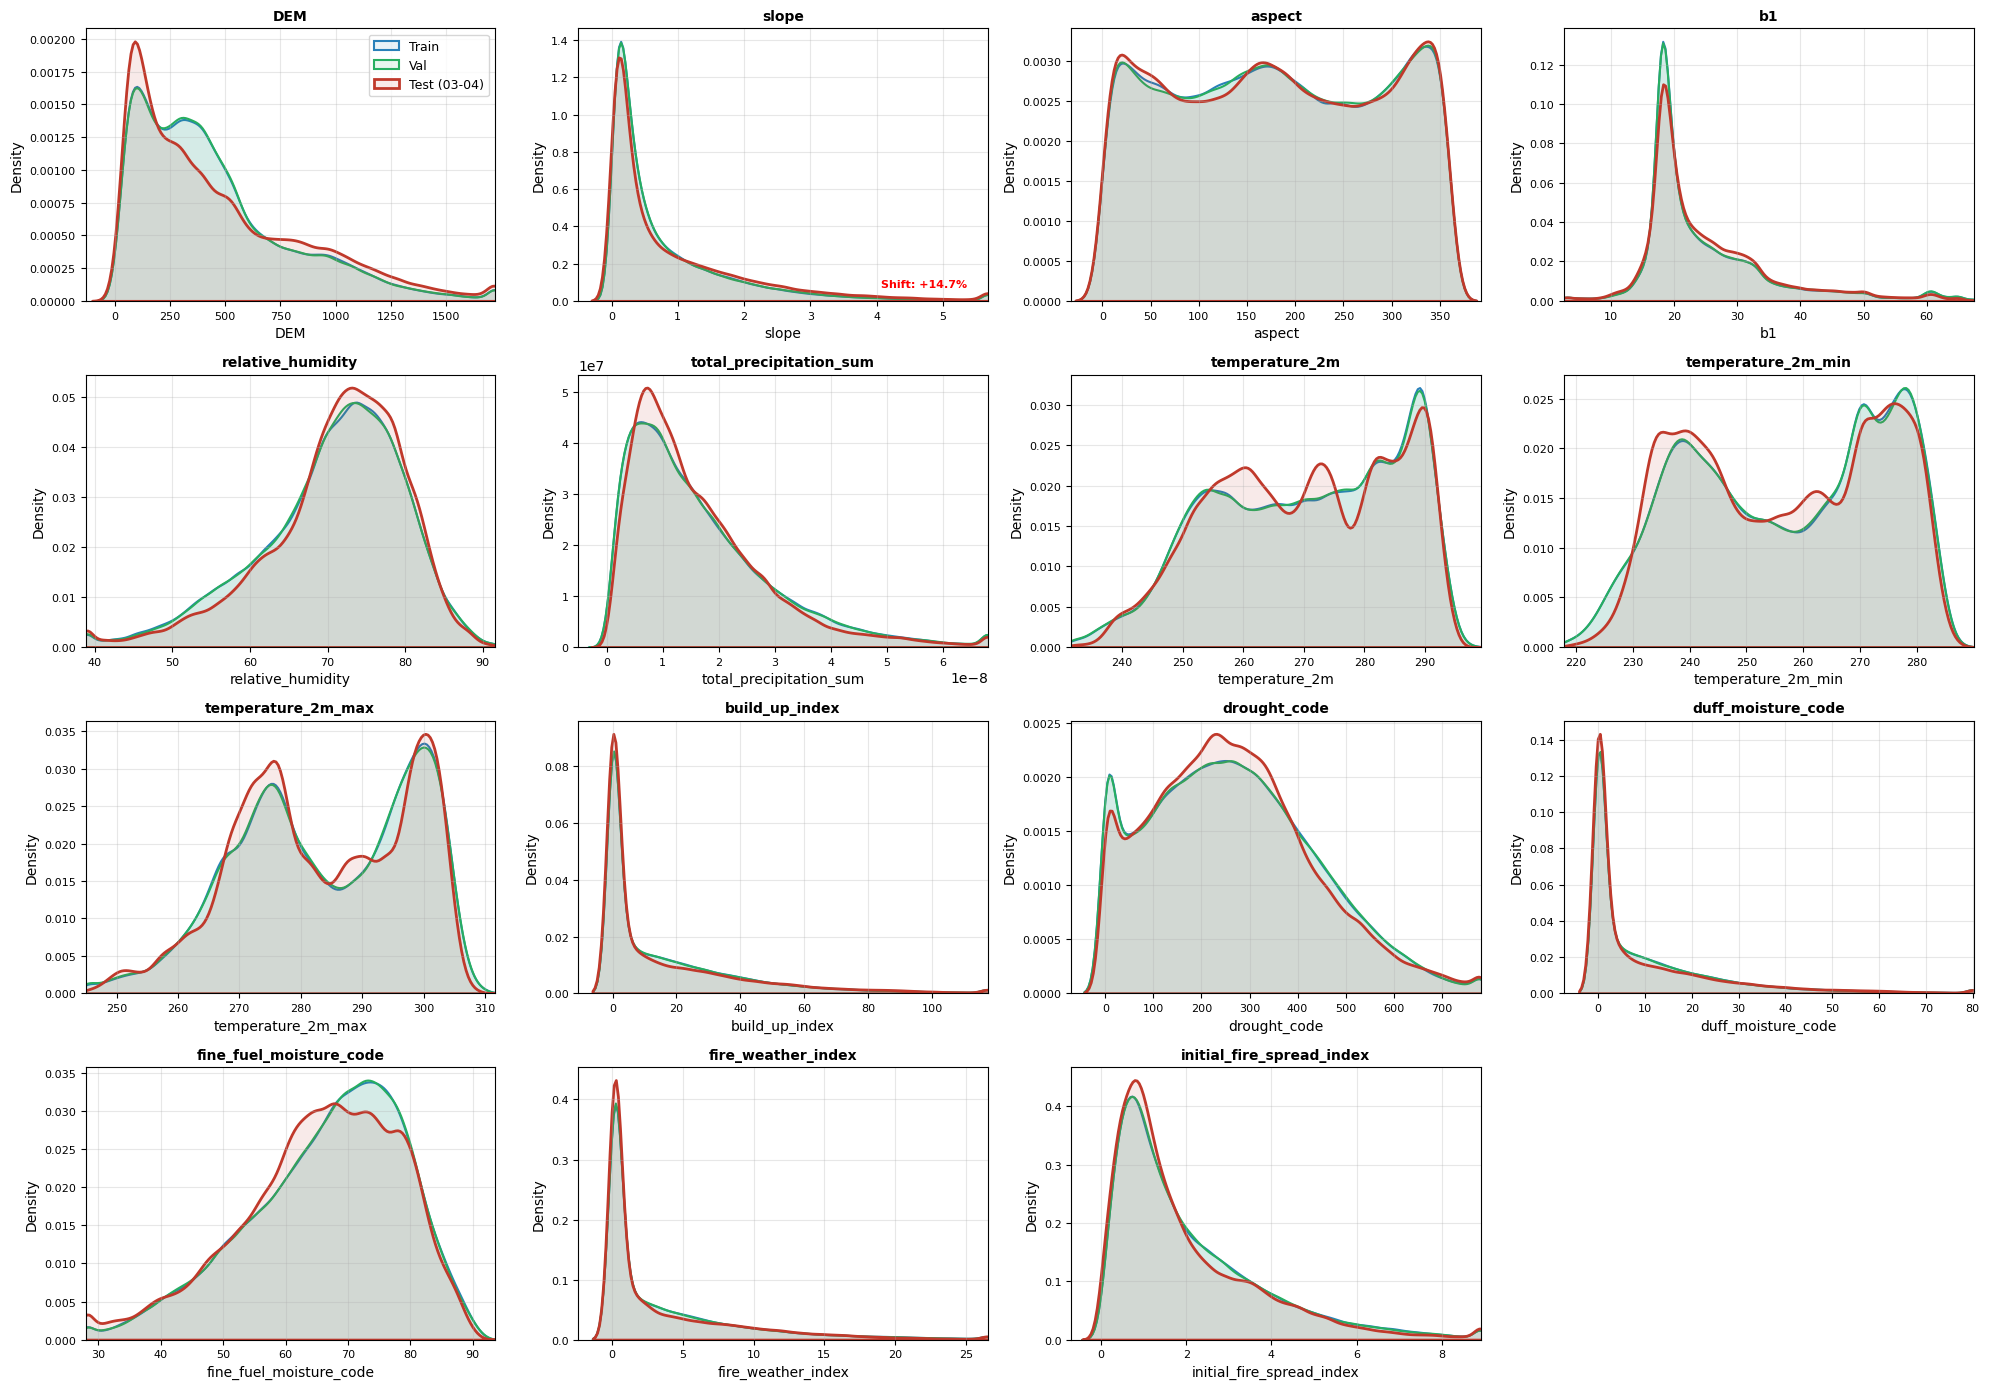

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Plot Covariate Distributions: Train vs Validation vs Test
-- Detects Covariate Shift --

Features:
- Loads the dataset (subsampled for speed/memory safety).
- Replicates the exact Train/Val/Test split used in training.
- Plots KDE (Kernel Density Estimate) for each feature.
- Saves high-res multipanel PNG.
"""

import os
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.dataset as ds
from sklearn.model_selection import train_test_split

# ============================================================
# CONFIG
# ============================================================

DATASET_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/parquet_cems_with_fraction_dataset_burnedlab_mask_analytical")
OUT_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/figures")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PNG = OUT_DIR / "covariate_distributions_multipanel.png"

# Features to plot
FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity",
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min",
    "temperature_2m_max", "build_up_index", "drought_code",
    "duff_moisture_code", "fine_fuel_moisture_code",
    "fire_weather_index", "initial_fire_spread_index",
]

TEST_YEARS = [2003, 2004]
VAL_SIZE = 0.20
RANDOM_STATE = 42

# Sample size for plotting (plotting 60M points is slow and illegible; 100k is statistically sufficient)
SAMPLE_SIZE = 200_000 

# ============================================================
# HELPERS
# ============================================================

def prepare_df_cleaned(df: pd.DataFrame):
    df = df.copy()
    
    # 1. Year & B1
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
    if "b1" in df.columns:
        df["b1"] = pd.to_numeric(df["b1"], errors="coerce").round().astype("Int64")

    # 2. Filter Negative FWI (Same as training script)
    fwi_cols = ["duff_moisture_code", "drought_code", "fine_fuel_moisture_code", "build_up_index"]
    for c in fwi_cols:
        if c in df.columns:
            df = df[df[c] >= 0]

    # 3. NaNs
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=FEATURES + ["year"])
    
    # 4. Cast Features
    for c in FEATURES:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")
        
    return df

def load_data_splits():
    print(f"Loading data from: {DATASET_DIR}")
    
    # Load entire dataset columns needed (pyarrow is fast)
    dset = ds.dataset(str(DATASET_DIR), format="parquet", partitioning="hive")
    cols = FEATURES + ["year"]
    
    # We load everything first to ensure correct splitting, 
    # but we might downsample immediately after if memory is tight.
    # For 60M rows, we need to be careful. Let's load a random fraction if dataset is huge.
    
    # Approach: Load table, convert to pandas
    table = dset.to_table(columns=cols)
    df = table.to_pandas()
    
    print(f"Total Rows Loaded: {len(df):,}")
    
    df = prepare_df_cleaned(df)
    print(f"Rows after cleaning: {len(df):,}")
    
    # Split Test
    mask_test = df["year"].isin(TEST_YEARS)
    df_test = df[mask_test]
    df_tv = df[~mask_test]
    
    # Split Train/Val
    df_train, df_val = train_test_split(
        df_tv, test_size=VAL_SIZE, random_state=RANDOM_STATE
    )
    
    # Subsample for plotting (Distributions don't need 50M points)
    if len(df_train) > SAMPLE_SIZE:
        df_train = df_train.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    if len(df_val) > SAMPLE_SIZE:
        df_val = df_val.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
    if len(df_test) > SAMPLE_SIZE:
        df_test = df_test.sample(n=SAMPLE_SIZE, random_state=RANDOM_STATE)
        
    print(f"Plotting Samples - Train: {len(df_train):,}, Val: {len(df_val):,}, Test: {len(df_test):,}")
    
    return df_train, df_val, df_test

# ============================================================
# PLOTTING
# ============================================================

def plot_distributions(df_train, df_val, df_test):
    n_features = len(FEATURES)
    ncols = 4
    nrows = math.ceil(n_features / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.5*nrows))
    axes = axes.flatten()
    
    # Colors
    c_train = "#2980b9" # Blue
    c_val   = "#27ae60" # Green
    c_test  = "#c0392b" # Red
    
    print("Generating plots...")
    
    for i, feature in enumerate(FEATURES):
        ax = axes[i]
        
        # Clip extreme outliers for better visualization (1st - 99th percentile of Train)
        # This prevents one crazy pixel from squashing the whole plot
        low = np.percentile(df_train[feature], 1)
        high = np.percentile(df_train[feature], 99)
        
        # Add a small buffer
        margin = (high - low) * 0.1
        xmin, xmax = low - margin, high + margin
        
        # Plot KDEs
        # We perform clipping in the data passed to plotting to ensure KDE focuses on main body
        d_train = df_train[feature].clip(xmin, xmax)
        d_val   = df_val[feature].clip(xmin, xmax)
        d_test  = df_test[feature].clip(xmin, xmax)
        
        sns.kdeplot(d_train, ax=ax, color=c_train, fill=True, alpha=0.1, linewidth=1.5, label="Train")
        sns.kdeplot(d_val,   ax=ax, color=c_val,   fill=True, alpha=0.1, linewidth=1.5, label="Val")
        sns.kdeplot(d_test,  ax=ax, color=c_test,  fill=True, alpha=0.1, linewidth=2.0, label="Test (03-04)")
        
        ax.set_title(feature, fontsize=10, fontweight="bold")
        ax.set_xlim(xmin, xmax)
        ax.tick_params(labelsize=8)
        ax.grid(True, alpha=0.3)
        
        # Add legend only to the first plot to reduce clutter
        if i == 0:
            ax.legend(loc="upper right", fontsize=9)
            
        # Check for Shift (Simple Mean Comparison printed on plot)
        mean_train = d_train.mean()
        mean_test = d_test.mean()
        diff_pct = (mean_test - mean_train) / (mean_train + 1e-6) * 100
        
        # Annotate if shift is large (>10%)
        if abs(diff_pct) > 10:
            ax.text(0.95, 0.05, f"Shift: {diff_pct:+.1f}%", 
                    transform=ax.transAxes, ha="right", color="red", fontsize=8, fontweight="bold")

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
        
    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=150)
    print(f"✅ Plot saved to: {OUT_PNG}")

# ============================================================
# MAIN
# ============================================================

def main():
    df_train, df_val, df_test = load_data_splits()
    plot_distributions(df_train, df_val, df_test)

if __name__ == "__main__":
    main()

In [2]:
't'

't'

Now lets take that model, and get pixels which were flagged as TP and FP and predict on only those pixels. 

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import features
import xgboost as xgb

# ============================================================
# CONFIG
# ============================================================

# Directory containing the analytical "pred_vs_obs" shapefiles
SHP_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction/stage_1_model_analytical/pred_vs_obs_shapefiles_annual_analytical")

# Monthly TIFFs containing the actual feature data
IN_TIF_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/training_e5l_cems_firecci_with_fraction")

# UPDATED: Point to the NEW "Area Match" Model
MODEL_PATH = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/ml_training/xgb_area_match_with_b1_2003_2004/models/xgb_area_match_best.json")

# UPDATED: New output directory for these specific predictions
OUT_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/predictions_area_match_2003_2004_analytical")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# 15 Predictors used by the model (Must match training order)
FEATURES = [
    "DEM", "slope", "aspect", "b1", "relative_humidity", 
    "total_precipitation_sum", "temperature_2m", "temperature_2m_min", 
    "temperature_2m_max", "build_up_index", "drought_code", 
    "duff_moisture_code", "fine_fuel_moisture_code", 
    "fire_weather_index", "initial_fire_spread_index"
]

# ============================================================
# Helpers
# ============================================================

def get_annual_shp(year):
    path = SHP_DIR / f"cems_e5l_firecci_{year}_annual_grid1deg_pred_vs_obs_analytical.shp"
    return path if path.exists() else None

def get_monthly_tif(year, month):
    pattern = f"cems_e5l_firecci_{year}_{month}_with_fraction.tif"
    path = IN_TIF_DIR / pattern
    return path if path.exists() else None

# ============================================================
# Main Prediction Logic
# ============================================================

def main():
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found: {MODEL_PATH}")

    # Load XGBoost model
    print(f"Loading model: {MODEL_PATH}")
    booster = xgb.Booster()
    booster.load_model(str(MODEL_PATH))
    
    # Identify available years from shapefiles
    shp_files = list(SHP_DIR.glob("*_analytical.shp"))
    years = sorted([int(re.findall(r'firecci_(\d{4})_', f.name)[0]) for f in shp_files if re.search(r'firecci_(\d{4})_', f.name)])
    
    if not years:
        print(f"No shapefiles found in {SHP_DIR}")
        return

    print(f"Found {len(years)} years to process: {years}")
    
    for year in years:
        shp_path = get_annual_shp(year)
        if not shp_path:
            print(f"Skipping {year}: Expected file not found at {shp_path}")
            continue
        
        print(f"\n--- Starting Year: {year} ---")
        gdf = gpd.read_file(shp_path)
        
        # Filter for TP and FP (case-insensitive check)
        if 'pred_obs' not in gdf.columns:
            print(f"Column 'pred_obs' missing in {shp_path.name}. Skipping.")
            continue

        mask_gdf = gdf[gdf['pred_obs'].str.upper().isin(['TP', 'FP'])].copy()
        
        if mask_gdf.empty:
            print(f"No TP/FP regions found for {year}. Skipping.")
            continue

        print(f"Processing {len(mask_gdf)} TP/FP coarse cells...")

        for month in range(1, 13):
            tif_path = get_monthly_tif(year, month)
            if not tif_path:
                continue
            
            out_name = OUT_DIR / f"pred_area_match_{year}_{month:02d}.tif"
            if out_name.exists():
                print(f"Month {month:02d} already exists. Skipping.")
                continue

            try:
                with rio.open(tif_path) as src:
                    # 1. Align CRS
                    if mask_gdf.crs != src.crs:
                        mask_gdf = mask_gdf.to_crs(src.crs)
                    
                    # 2. Rasterize TP/FP mask
                    mask = features.rasterize(
                        [(geom, 1) for geom in mask_gdf.geometry],
                        out_shape=src.shape,
                        transform=src.transform,
                        fill=0,
                        dtype='uint8'
                    )
                    
                    if not np.any(mask == 1):
                        continue

                    # 3. Read and Prepare Data
                    img_data = src.read()
                    nodata_val = src.nodata

                    # Extract pixels under the mask
                    idx_y, idx_x = np.where(mask == 1)
                    pixels = img_data[:, idx_y, idx_x].T  # Shape: (N_pixels, N_bands)
                    
                    # Ensure we have at least 15 features
                    if pixels.shape[1] < 15:
                        print(f"Error: {tif_path.name} has only {pixels.shape[1]} bands (need 15+).")
                        continue
                    
                    # A. Subset features
                    pixels = pixels[:, :15]

                    # B. CRITICAL FIX: Handle NoData / Negative Values
                    # Convert to float to allow NaNs
                    pixels = pixels.astype('float32')
                    
                    # If specific nodata value exists, replace with NaN
                    if nodata_val is not None:
                        pixels[pixels == nodata_val] = np.nan
                    
                    # Also catch "hardcoded" missing values (negative FWI/Code)
                    # Training set dropped these; here we set them to NaN so XGBoost handles them as "missing"
                    pixels[pixels < -9000] = np.nan 

                    # 4. Predict
                    dmat = xgb.DMatrix(pixels, feature_names=FEATURES)
                    preds = booster.predict(dmat)
                    
                    # 5. Save (Float probabilities)
                    out_proba = np.zeros((src.height, src.width), dtype='float32')
                    out_proba[idx_y, idx_x] = preds
                    
                    out_meta = src.meta.copy()
                    out_meta.update(
                        dtype='float32', 
                        count=1, 
                        nodata=0,
                        compress='deflate'
                    )
                    
                    with rio.open(out_name, 'w', **out_meta) as dst:
                        dst.write(out_proba, 1)
                    
                    print(f"Saved: {out_name.name} (Predicted {len(preds):,} pixels)")

            except Exception as e:
                print(f"Failed to process {year}-{month:02d}: {e}")

    print("\n✅ All available years and months processed.")

if __name__ == "__main__":
    main()

In [6]:
't'

't'

Now save burned area per year

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Calculate Burned Area (Mha) per Ecoregion per Year
-- AREA MATCH 2003-2004 VERSION --

Inputs:
- Monthly prediction TIFFs from the "Area Match" model experiment.
- Ecoregion shapefile.

Outputs:
- CSV with columns: [ecoregion, year, ba_pred_area_match_Mha]
"""

import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.features import geometry_mask
from tqdm import tqdm

# ============================
# CONFIG
# ============================
YEARS  = list(range(2001, 2020)) 
MONTHS = list(range(1, 13))

# UPDATED: Directory where we saved the 'Area Match' predictions
PRED_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/predictions_area_match_2003_2004_analytical")

# UPDATED: Set to the "Oracle Threshold" found in your training log (~0.2617)
# This is the threshold required to match the total burned area for 2003/2004.
# PROB_THRESHOLD = 0.26
PROB_THRESHOLD = 0.70

# Ecoregion shapefile
ECOS_PATH = "/explore/nobackup/people/spotter5/helene/raw/merge_eco_v2.shp"
ECO_ID_COL = "ecoregion"

# Output CSV
OUT_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries_analytical")
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_CSV = OUT_DIR / "ba_ecoregion_area_match_2003_2004.csv"

# ============================
# HELPERS
# ============================

def get_annual_mask(year, pred_dir, threshold):
    """
    Aggregates monthly probability TIFFs into a single annual binary mask.
    Returns: (annual_mask_bool, transform, crs)
    """
    annual = None
    transform = None
    crs = None
    
    found_any = False

    for month in range(1, 13):
        # UPDATED Pattern: pred_area_match_YYYY_MM.tif
        tif_path = pred_dir / f"pred_area_match_{year}_{month:02d}.tif"
        if not tif_path.exists():
            continue
            
        found_any = True
        with rio.open(tif_path) as src:
            prob = src.read(1)
            # Binary mask: 1 if prob >= threshold, else 0
            monthly_burn = (prob >= threshold).astype(bool)
            
            if annual is None:
                annual = monthly_burn
                transform = src.transform
                crs = src.crs
            else:
                # Logical OR accumulation (union of burns throughout the year)
                annual = annual | monthly_burn
                
    if not found_any:
        return None, None, None
                
    return annual, transform, crs

def get_pixel_area_grid(shape, transform, crs):
    """
    Generates a grid of pixel areas in Mha.
    Handles EPSG:4326 by calculating area based on latitude.
    """
    height, width = shape
    
    # Resolution (degrees if 4326)
    res_x = abs(transform.a)
    res_y = abs(transform.e)

    if crs.is_geographic:
        # EPSG:4326 - Area depends on latitude
        # 1 degree lat ~ 111,320 meters
        # 1 degree lon ~ 111,320 * cos(lat) meters
        
        # Get latitude of every row center
        rows = np.arange(height) + 0.5
        _, lats = rio.transform.xy(transform, rows, np.zeros_like(rows), offset='center')
        lats = np.array(lats)
        
        # Calculate area per pixel for each row (in square meters)
        lat_rads = np.radians(lats)
        
        # Width varies by latitude
        pixel_width_m = res_x * 111320 * np.cos(lat_rads)
        # Height is effectively constant
        pixel_height_m = res_y * 111320
        
        row_areas_m2 = pixel_width_m * pixel_height_m
        
        # Broadcast to full grid (H, W)
        area_grid_m2 = row_areas_m2[:, np.newaxis] * np.ones((1, width))
        
    else:
        # Projected CRS (Meters) - Constant area assumption
        pixel_area_m2 = res_x * res_y
        area_grid_m2 = np.full(shape, pixel_area_m2)

    # Convert m2 to Million Hectares (Mha)
    # 1 Ha = 10,000 m2
    # 1 Mha = 10^6 Ha = 10^10 m2
    area_grid_Mha = area_grid_m2 / 1e10
    
    return area_grid_Mha

# ============================
# MAIN
# ============================

def main():
    if not PRED_DIR.exists():
        raise FileNotFoundError(f"Prediction directory not found: {PRED_DIR}")

    print("Loading ecoregions...")
    ecos = gpd.read_file(ECOS_PATH)

    results = []

    print(f"Scanning years {min(YEARS)} to {max(YEARS)}...")
    print(f"Using Threshold: {PROB_THRESHOLD} (Oracle Match)")
    
    for year in tqdm(YEARS, desc="Processing Years"):
        
        # 1. Load predictions
        annual_mask, transform, crs = get_annual_mask(year, PRED_DIR, PROB_THRESHOLD)
        
        if annual_mask is None:
            continue

        # 2. Reproject ecoregions if needed
        if ecos.crs != crs:
            ecos_proj = ecos.to_crs(crs)
        else:
            ecos_proj = ecos

        # 3. Create Area Grid
        pixel_area_map = get_pixel_area_grid(annual_mask.shape, transform, crs)
        height, width = annual_mask.shape
        
        # 4. Iterate Ecoregions
        for idx, row in ecos_proj.iterrows():
            eco_id = row[ECO_ID_COL]
            geom = row.geometry
            
            if geom is None or geom.is_empty:
                continue
                
            try:
                # Create mask for this ecoregion
                # geometry_mask returns True OUTSIDE the shape by default unless invert=True
                eco_mask = geometry_mask(
                    [geom],
                    transform=transform,
                    invert=True, 
                    out_shape=(height, width),
                    all_touched=False 
                )
                
                # Intersect Prediction & Ecoregion
                burned_in_eco_mask = annual_mask & eco_mask
                
                if burned_in_eco_mask.any():
                    ba_Mha = pixel_area_map[burned_in_eco_mask].sum()
                else:
                    ba_Mha = 0.0
                
                results.append({
                    "ecoregion": eco_id,
                    "year": year,
                    "ba_pred_area_match_Mha": ba_Mha
                })
                
            except Exception as e:
                print(f"  Error processing eco {eco_id} in {year}: {e}")

    # Save
    if results:
        df_results = pd.DataFrame(results)
        df_results.to_csv(OUT_CSV, index=False)
        print(f"\n✅ DONE. Results saved to:\n{OUT_CSV}")
        print(f"Total rows: {len(df_results)}")
    else:
        print("\n⚠️ No results generated (did not find any prediction files).")

if __name__ == "__main__":
    main()

Loading ecoregions...
Scanning years 2001 to 2019...
Using Threshold: 0.7 (Oracle Match)


Processing Years: 100%|██████████| 19/19 [02:10<00:00,  6.87s/it]


✅ DONE. Results saved to:
/explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries_analytical/ba_ecoregion_area_match_2003_2004.csv
Total rows: 513


Now extract burned area and compare to other products per ecoregion in multipanel way

Now make multipanel burned area comparison plot

Now extract burned area and compare to other products per ecoregion in multipanel way

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Compare Area-Match Predictions to MCD64A1 and FireCCI native products (2001-2019).
-- AREA MATCH 2003-2004 VERSION --

Features:
- Highlights the Test Years (2003-2004) with a shaded background.
- Includes an ecoregion-summed "Total" panel.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# ============================
# CONFIG
# ============================

# Directory containing the REFERENCE data (MCD/FireCCI)
REF_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries")

# Directory for NEW outputs (Analytical)
OUT_DIR = Path("/explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries_analytical")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Files
BASE_CSV     = REF_DIR / "burned_area_by_ecoregion_predictions.csv"  # Contains MCD/FireCCI cols

# UPDATED: Pointing to the NEW 'Area Match' predictions CSV
NEW_PRED_CSV = OUT_DIR / "ba_ecoregion_area_match_2003_2004.csv" 
FINAL_CSV    = OUT_DIR / "burned_area_merged_area_match_2003_2004.csv"
OUT_PNG      = OUT_DIR / "burned_area_plot_area_match_2003_2004.png"

# Column Names
ECO_ID_COL  = "ecoregion"
MCD_COL     = "ba_mcd_native_Mha"
FIRECCI_COL = "ba_firecci_native_Mha"

# UPDATED: Column name from the Area Match CSV
PRED_COL    = "ba_pred_area_match_Mha"

YEAR_START, YEAR_END = 2001, 2019

# EXCLUSIONS
EXCLUDE_ECOS = {"WATER", "MIXED WOOD SHIELD", "TEMPERATE PRAIRIES", "WESTERN CORDILLERA"}

# PROFESSIONAL COLORS
COLORS = {
    MCD_COL: "#2c3e50",      # Slate Grey
    FIRECCI_COL: "#e67e22",  # Vivid Orange
    PRED_COL: "#16a085"      # Deep Teal
}

def nice_pred_label(colname: str) -> str:
    if colname == "ba_pred_area_match_Mha":
        return "Prediction (Area Match)"
    return colname

# ============================
# MAIN
# ============================

def main():
    print(f"Loading Base Reference Data from: {BASE_CSV}")
    if not BASE_CSV.exists():
        raise FileNotFoundError(f"Base CSV not found: {BASE_CSV}")
        
    print(f"Loading New Predictions from: {NEW_PRED_CSV}")
    if not NEW_PRED_CSV.exists():
        raise FileNotFoundError(f"Prediction CSV not found: {NEW_PRED_CSV}")

    # --- 1. Load, Filter and Merge ---
    df_base = pd.read_csv(BASE_CSV)
    df_pred = pd.read_csv(NEW_PRED_CSV)
    
    # Merge on Ecoregion and Year
    df = df_base.merge(df_pred, on=[ECO_ID_COL, "year"], how="left")
    
    # Filter years 2001-2019
    df = df[(df["year"] >= YEAR_START) & (df["year"] <= YEAR_END)].copy()
    
    # Save merged data for inspection
    df.to_csv(FINAL_CSV, index=False)
    print(f"Merged CSV saved to: {FINAL_CSV}")

    # --- 2. Prepare Subplots ---
    ecos_all = sorted(df[ECO_ID_COL].dropna().unique())
    ecos_list = [e for e in ecos_all if e not in EXCLUDE_ECOS]
    
    # Add a virtual "TOTAL" entry to the list
    plot_list = ecos_list + ["TOTAL BURNED AREA"]
    n_panels = len(plot_list)

    ncols = 4
    nrows = int(np.ceil(n_panels / ncols))

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, 
        figsize=(4 * ncols, 3.5 * nrows), 
        sharex=True
    )
    axes = axes.flatten()

    handles_for_legend = None

    # --- 3. Plotting Loop ---
    for i, title in enumerate(plot_list):
        ax = axes[i]
        
        if title == "TOTAL BURNED AREA":
            # Aggregate sum across all ecoregions
            df_plot = df.groupby("year")[[MCD_COL, FIRECCI_COL, PRED_COL]].sum().reset_index()
            ax.set_facecolor('#fdfefe') # Light highlight for total panel
        else:
            df_plot = df[df[ECO_ID_COL] == title].sort_values("year")

        # --- HIGHLIGHT TEST YEARS (2003-2004) ---
        # Draw a shaded rectangle behind the plot for the test period
        # Using 2002.5 to 2004.5 ensures the bars/points for 03/04 fall inside
        ax.axvspan(2002.5, 2004.5, color='gray', alpha=0.15, zorder=0, lw=0)

        # Plot datasets
        p1, = ax.plot(df_plot["year"], df_plot[MCD_COL], marker="o", markersize=4, 
                      label="MCD64A1", color=COLORS[MCD_COL], linewidth=1.5)
        p2, = ax.plot(df_plot["year"], df_plot[FIRECCI_COL], marker="s", markersize=4, 
                      label="Fire CCI", color=COLORS[FIRECCI_COL], linewidth=1.5)
        
        # Only plot predictions if they exist (points will show up for years processed)
        p3, = ax.plot(df_plot["year"], df_plot[PRED_COL], marker="^", markersize=4, 
                      label=nice_pred_label(PRED_COL), color=COLORS[PRED_COL], linewidth=2)

        ax.set_title(str(title), fontsize=11, fontweight='bold')
        ax.grid(True, ls=":", alpha=0.6)
        ax.tick_params(axis='both', labelsize=9)
        
        # Set X-ticks to be cleaner (integers)
        ax.set_xticks(np.arange(YEAR_START, YEAR_END + 1, 2))

        if i == 0:
            handles_for_legend = [p1, p2, p3]

        # Axis labeling
        if i >= (n_panels - ncols):
            ax.set_xlabel("Year", fontsize=10)
        if i % ncols == 0:
            ax.set_ylabel("Burned Area (Mha)", fontsize=10)

        # Handle scaling
        vals = df_plot[[MCD_COL, FIRECCI_COL, PRED_COL]]
        y_max = vals.max().max() if not vals.empty else 0
        if pd.notna(y_max) and y_max < 0.005:
            ax.set_ylim(0, 0.01)

    # Clean up empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Global legend
    if handles_for_legend:
        # Create a proxy artist for the test set shading
        patch_test = mpatches.Patch(color='gray', alpha=0.15, label='Test Set (03-04)')
        handles_for_legend.append(patch_test)
        
        fig.legend(
            handles=handles_for_legend,
            labels=["MCD64A1", "Fire CCI", nice_pred_label(PRED_COL), "Test Set (03-04)"],
            loc="lower center", 
            ncol=4, 
            fontsize=12,
            frameon=False,
            bbox_to_anchor=(0.5, -0.02)
        )

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(OUT_PNG, dpi=250, bbox_inches="tight")
    plt.close()

    print(f"✅ Comparison plot saved to:\n   {OUT_PNG}")

if __name__ == "__main__":
    main()

Loading Base Reference Data from: /explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries/burned_area_by_ecoregion_predictions.csv
Loading New Predictions from: /explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries_analytical/ba_ecoregion_area_match_2003_2004.csv
Merged CSV saved to: /explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries_analytical/burned_area_merged_area_match_2003_2004.csv
✅ Comparison plot saved to:
   /explore/nobackup/people/spotter5/clelland_fire_ml/burned_area_summaries_analytical/burned_area_plot_area_match_2003_2004.png


In [9]:
't'

't'